<a href="https://colab.research.google.com/github/fatima2003/DataMiningClustering/blob/main/CW_PART3_UG_GROUP11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cv2
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report, make_scorer, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from IPython.core.display import display, HTML
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import pointbiserialr

from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import get_scorer_names

# **Data Preprocessing Functions**

## **Normalization Pipeline**

In [ ]:
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),            # Min-Max normalization
        #('std_scaler', StandardScaler())
    ])

## **Function that does PCA**

In [ ]:
def pca_on_num_components(n_components, data):
  pca = PCA(n_components = n_components)
  return pca.fit_transform(data)

## **Function that does Gaussian Blur then Adaptive Binary Thresholding**

In [ ]:
def gaussian_blur_adaptive_threshold(dataset):
  image_height = 48
  image_width = 48
  processed_images = []

  # Loop over each row in x_train
  for index, row in dataset.iterrows():
      # Reshape the row into the original image dimensions
      image = np.array(row).reshape(image_height, image_width).astype('uint8')

      # Apply Gaussian Blur
      blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

      # Apply Adaptive Thresholding
      thresholded_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                cv2.THRESH_BINARY, 11, 2)

      # Flatten the image back to 1D and append to the list
      processed_images.append(thresholded_image.flatten())

  # Convert the list of processed images back to a DataFrame
  # processed_x_train = pd.DataFrame(processed_images)
  return pd.DataFrame(processed_images)

  # Now, 'processed_x_train' contains the preprocessed images

## **Function to View Range of Processed Images vs Original Images**

In [ ]:
def view_images(num_images_to_show, first_image_index, processed_images_dataframe, x_train):
    image_height = 48
    image_width = 48

    # Set up a matplotlib figure
    plt.figure(figsize=(10, 2 * num_images_to_show))

    for i in range(num_images_to_show):
        # Original Image
        plt.subplot(num_images_to_show, 2, i * 2 + 1)
        original_image = np.array(x_train.iloc[i + first_image_index]).reshape(image_height, image_width).astype('uint8')
        plt.imshow(original_image, cmap='gray')
        plt.title(f"Original Image {i + 1 + first_image_index}")
        plt.axis('off')

        # Processed Image
        plt.subplot(num_images_to_show, 2, i * 2 + 2)
        processed_image = np.array(processed_images_dataframe.iloc[i + first_image_index]).reshape(image_height, image_width)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"Processed Image {i + 1 + first_image_index}")
        plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

# **Datasets**

## **Complete Dataset**

In [ ]:
x_train = pd.read_csv('drive/MyDrive/F20DL/datasets/CW_Dataset/Traffic_Sign/CompleteDataSet/x_train_all.csv')
y_train = pd.read_csv('drive/MyDrive/F20DL/datasets/CW_Dataset/Traffic_Sign/CompleteDataSet/y_train_all.csv')
x_test = pd.read_csv('drive/MyDrive/F20DL/datasets/CW_Dataset/Traffic_Sign/CompleteDataSet/x_test_all.csv')
y_test = pd.read_csv('drive/MyDrive/F20DL/datasets/CW_Dataset/Traffic_Sign/CompleteDataSet/y_test_all.csv')

In [ ]:
x_norm = num_pipeline.fit_transform(x_train)

x_pca2 = pca_on_num_components(2, x_train)
x_pca2_norm = num_pipeline.fit_transform(x_pca2)

In [ ]:
y_test.head()

0
0  1
1  4
2  6
3  7
4  4

## **Processed Datasets with Gaussian Blur then Adaptive Thresholding**

* Gaussian Blur helps smoothing the images, reducing noise and irrelevant details making it easier for the model to identify relevant patterns.
* Binary Adaptive Thresholding further simplifies the image by focusing on important features, which is particularly effective in handling varied lighting conditions in traffic sign images.
* The combination of blurring and thresholding enhances the contrast between the signs and their backgrounds, making it easier for the decision tree to distinguish between different classes. This is especially beneficial for the classes that have subtle differences.

In [ ]:
processed_x_train = gaussian_blur_adaptive_threshold(x_train)
processed_x_test = gaussian_blur_adaptive_threshold(x_test)

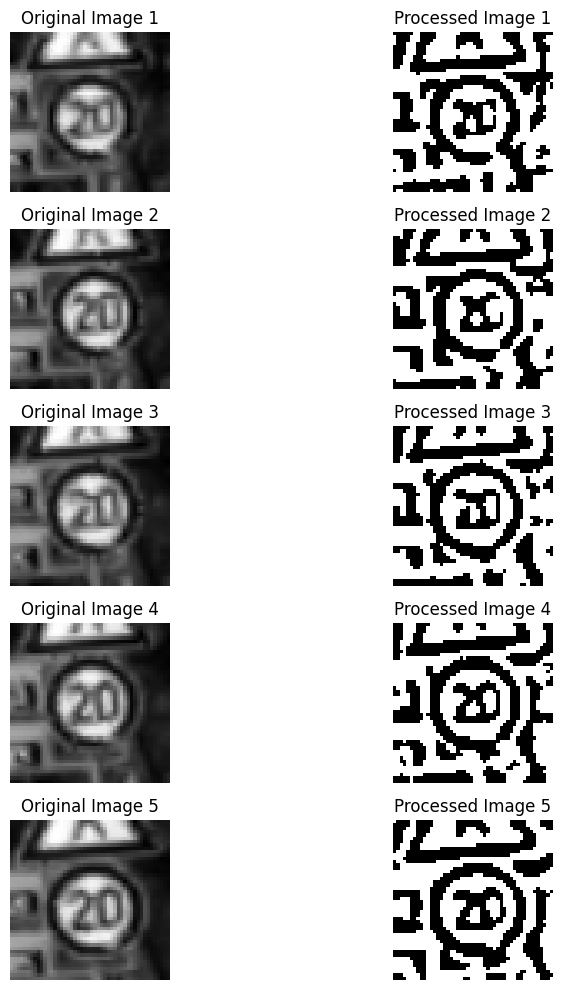

In [ ]:
view_images(5, 0, processed_x_train, x_train)

# **Functions**

### **Function to fit Decision Tree Classifier**

In [ ]:
# Fits a classifier and returns the predicted values and probabilities
def fit_tree_clf(classifier, x_train, y_train, x_test=None, y_test=None):
  if (x_test == None or y_test == None):  # Predicts on training set if test set is not provided
    x_test, y_test = x_train, y_train
  tree_clf = classifier
  tree_clf.fit(x_train, y_train)
  y_pred = tree_clf.predict(x_test)
  y_proba = tree_clf.predict_proba(x_test)
  #print("Test set predictions:\n", np.array(y_pred))
  #print("Actual predictions:\n", np.array(y_test))
  return y_pred, y_proba

### **Function that Shows Difference in Accuracies of Datasets on the same Decision Tree**

In [ ]:
def display_accuracies(clf, x_train, y_train, x_test, y_test):
  train_score = clf.score(x_train,y_train)*100
  test_score = clf.score(x_test,y_test)*100
  difference = train_score - test_score

  print(f"Accuracy on training set: {train_score:.2f}%")
  print(f"Accuracy on testing set: {test_score:.2f}%")
  print(f"Difference: {difference:.2f}%")

### **Function to display Classification Report**

In [ ]:
# Displays the classification report
def display_cf_report(y_true, y_pred):
  cf_report = classification_report(y_true, y_pred)
  print("\nClassification Report:\n", cf_report)

### **Function to display TPR and FPR**

In [ ]:
def display_TPR_FPR(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)

  FP = cm.sum(axis=0) - np.diag(cm)
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  print(f"True Positive Rate: {TPR}")

  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  print(f"False Positive Rate: {FPR}")

  # Calculate the average TPR and FPR
  avg_TPR = np.mean(TPR)
  avg_FPR = np.mean(FPR)

  # Print the average TPR and FPR
  print(f"Average True Positive Rate: {avg_TPR}")
  print(f"Average False Positive Rate: {avg_FPR}")

### **Function to plot Confusion Matrix**

In [ ]:
# Plots the confusion matrix
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def plot_confusion_matrix(y_test, y_pred, class_labels):
    ConfusionMatrixDisplay.from_predictions(y_true = y_test,
                                            y_pred = y_pred,
                                            display_labels = class_labels,
                                            cmap = "Blues")
    plt.show()
    print()

### **Function to display TPs and FPs for each class**

In [ ]:
# Displays the list of true positives and false positives for each class
def list_TP_FP(y_test_bin, y_pred_bin):
  # Compute TP and FP for each class
  TP = dict()
  FP = dict()

  n_classes = 10

  for i in range(n_classes):
      cm = confusion_matrix(y_test_bin[:, i], y_pred_bin[:, i])
      TP[i], FP[i] = cm[1, 1], cm[0, 1]

  print("________________________________________________________________________\n")
  display(HTML('<span style="font-size: 20px; font-weight: bold;">True Positives & False Positives of Each Class</span>'))

  # Define a header for the table
  header = "+-------+-----------------+------------------+"
  title_row = "| Class | True Positives  | False Positives  |"

  print(header)
  print(title_row)
  print(header)

  # Print each row of data
  for i in range(n_classes):
      row = f"| {i:^5} | {TP[i]:^15} | {FP[i]:^16} |"
      print(row)
      print(header)

### **Function to plot ROC and Macro-average ROC Curves**

In [ ]:
# lists that store necessary variables to generate a curve for all the models
macro_ave_roc_curves = []
all_fpr_list = []
mean_tpr_list = []
macro_ave_titles = []

# plots ROC and Macro-Average ROC
def plot_roc_curves(y_test_bin, y_proba, ROC_title, ave_ROC_title):
    n_classes = 4

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Create a single figure with two subplots
    plt.figure(figsize=(12, 6))

    # First subplot for individual ROC curves
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ROC_title)
    plt.legend(loc="lower right")

    # Calculate the macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate the ROC curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute the AUC
    mean_tpr /= n_classes

    # Compute the macro-average AUC score
    macro_roc_auc = auc(all_fpr, mean_tpr)

    macro_ave_roc_curves.append(macro_roc_auc)
    all_fpr_list.append(all_fpr)
    mean_tpr_list.append(mean_tpr)
    macro_ave_titles.append(ave_ROC_title)


    # Second subplot for the macro-average ROC curve
    plt.subplot(1, 2, 2)

    # Plotting the macro-average ROC curve
    plt.plot(all_fpr, mean_tpr, color='b',
             label=f'Macro-average ROC curve (area = {macro_roc_auc:0.2f})',
             lw=2, alpha=0.8)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ave_ROC_title)
    plt.legend(loc="lower right")

    # Display the entire figure
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_all_macro_ROC(title):
  plt.figure(figsize=(10, 8))

  # Generate colors
  colors2 = plt.cm.viridis(np.linspace(0, 1, len(all_fpr_list)))
  colors = cm.rainbow(np.linspace(0, 1, len(all_fpr_list)))

  for i in range(len(all_fpr_list)):
    plt.plot(all_fpr_list[i], mean_tpr_list[i], color=colors[i],
      label = macro_ave_titles[i] + " (area = {:.2f})".format(macro_ave_roc_curves[i]),
      lw=2, alpha=0.8)

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def plot_selected_roc_curves(selected_titles):
    # Check if the selected_titles list is empty
    if not selected_titles:
        print("No titles were provided for plotting.")
        return

    plt.figure(figsize=(10, 6))

    # Loop through each title in macro_ave_titles and plot if it's in selected_titles
    for i, title in enumerate(macro_ave_titles):
        if title in selected_titles:
            all_fpr = all_fpr_list[i]
            mean_tpr = mean_tpr_list[i]
            macro_roc_auc = macro_ave_roc_curves[i]

            plt.plot(all_fpr, mean_tpr, lw=2, alpha=0.8,
                     label=f'{title} (AUC = {macro_roc_auc:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Selected Macro-average ROC Curves')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# **Decision Trees Without Limits**

## **Training and Testing on Original Dataset without Preprocessing**

### **Decision Tree on Train Set**

#### **Make Decision Tree using Train Set**

In [ ]:
tree_clf_og = DecisionTreeClassifier(random_state=42)
tree_clf_og.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

#### **Accuracy of Decision Tree on Train Set**

The accuracy here is 1.0 or 100% as the decision tree has not been regularized, (i.e., its hyper-parameters have not been altered to account for overfitting). As a result, the tree structure adapts itself to the training data, fitting it very closely, if not perfectly.

In [ ]:
print(tree_clf_og.score(x_train, y_train))

1.0


#### **Evaluating Decision Tree on Train Set**


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690

True Positive Rate: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
False Positive Rate: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Average True Positive Rate: 1.0
Average False Positive Rate: 0.0


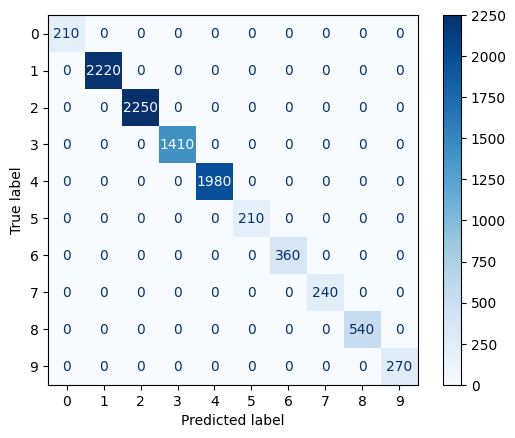


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       210       |        0         |
+-------+-----------------+------------------+
|   1   |      2220       |        0         |
+-------+-----------------+------------------+
|   2   |      2250       |        0         |
+-------+-----------------+------------------+
|   3   |      1410       |        0         |
+-------+-----------------+------------------+
|   4   |      1980       |        0         |
+-------+-----------------+------------------+
|   5   |       210       |        0         |
+-------+-----------------+------------------+
|   6   |       360       |        0         |
+-------+-----------------+------------------+
|   7   |       240       |        0         |
+-------+-----------------+------------------+
|   8   |       540       |        0         |
+-------+-----------------+------------------+
|   9   |    

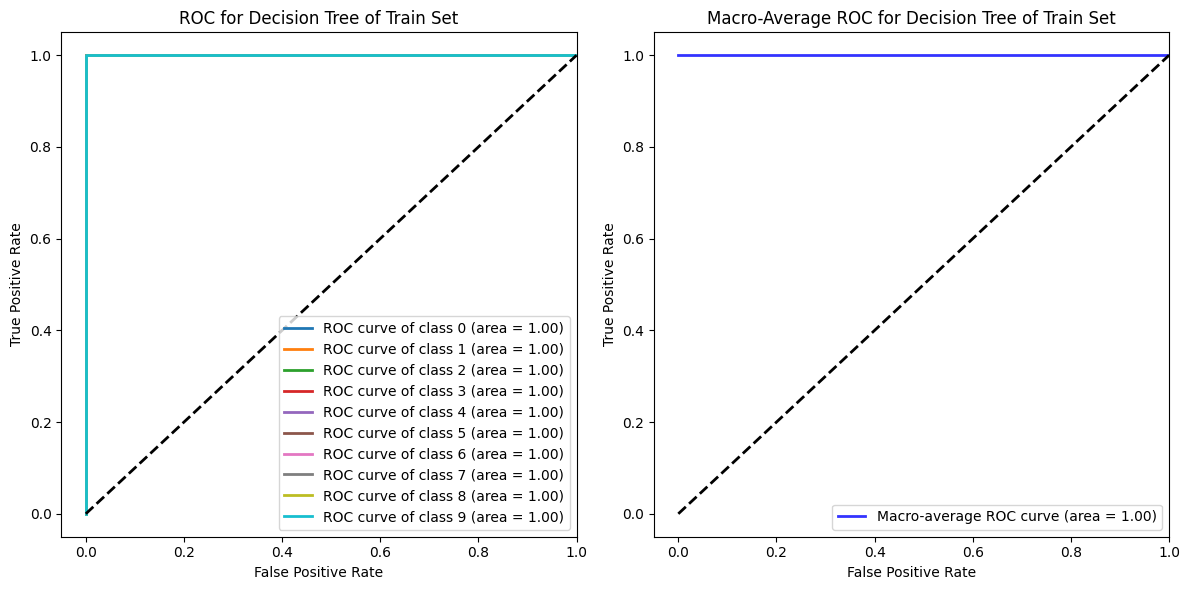

In [ ]:
y_pred_og, y_proba_og = fit_tree_clf(tree_clf_og, x_train, y_train)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_og = label_binarize(y_train, classes = classes)
y_pred_bin_og = label_binarize(y_pred_og, classes = classes)

# Call functions for evaluation
display_cf_report(y_train, y_pred_og)
display_TPR_FPR(y_train, y_pred_og)
plot_confusion_matrix(y_train, y_pred_og, classes)
list_TP_FP(y_test_bin_og, y_pred_bin_og)
plot_roc_curves(y_test_bin_og, y_proba_og, "ROC for Decision Tree of Train Set", "Macro-Average ROC for Decision Tree of Train Set")

#### **Conclusions**

* As seen above, there is 100% acuracy, TP rate, FP rate, Precision, Recall, F-measure and AUC. This is because the decision tree has learnt the training data to perfection and has overfitted.

In [ ]:
num_leaf_nodes = tree_clf_og.get_n_leaves()
print(f"Number of leaf nodes: {num_leaf_nodes}")

Number of leaf nodes: 743


* They are 743 leaf nodes but only 10 classes which means they are decision boundaries for even a few sample exceptions.

### **Decision tree using 10 Fold Cross Validation on Train Data**

#### **Make Decision Tree using 10-Fold CV**

In [ ]:
tree_clf_og_CV10 = DecisionTreeClassifier(random_state=42)
tree_clf_og_CV10.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

#### **Evaluation of Decision Tree using 10-Fold CV**

In [ ]:
scoring_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
scores_og_CV10 = cross_validate(tree_clf_og_CV10, x_train, y_train, cv=10, scoring=scoring_list, return_train_score=True)
scores_df_og_CV10 = pd.DataFrame(scores_og_CV10)
scores_df_og_CV10.mean()

fit_time                 20.153440
score_time                0.096265
test_accuracy             0.663571
train_accuracy            1.000000
test_precision_macro      0.588344
train_precision_macro     1.000000
test_recall_macro         0.579009
train_recall_macro        1.000000
test_f1_macro             0.573094
train_f1_macro            1.000000
test_roc_auc_ovr          0.769187
train_roc_auc_ovr         1.000000
dtype: float64

In [ ]:
print("Train Score: ", tree_clf_og_CV10.score(x_train, y_train))

Train Score:  1.0


#### **Conclusion**

* The decision tree model exhibits overfitting, as indicated by perfect training metrics (accuracy, precision, recall, F1, ROC-AUC all 100%) contrasted with lower test scores (accuracy 66.36%, precision 58.83%, recall 57.90%, F1 57.31%, ROC-AUC 76.92%). This disparity suggests the model is tailored too closely to the training data, impacting its ability to generalize. Pruning the decision tree, feature extraction and limiting the trees growth can improve the trees generalization.

### **Decision tree using Stratified 10 Fold Cross Validation on Train Data**

#### **Make Decision Tree using Stratified 10-Fold CV**

In [ ]:
tree_clf_og_SCV10 = DecisionTreeClassifier(random_state=42)
tree_clf_og_SCV10.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

#### **Evaluation of Decision Tree using Stratified 10-Fold CV**

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
scores_og_SCV10 = cross_validate(tree_clf_og_SCV10, x_train, y_train, cv=stratified_kfold, scoring=scoring_list, return_train_score=True)
scores_df_og_SCV10 = pd.DataFrame(scores_og_SCV10)
scores_df_og_SCV10.mean()

fit_time                 21.254755
score_time                0.106525
test_accuracy             0.829205
train_accuracy            1.000000
test_precision_macro      0.790515
train_precision_macro     1.000000
test_recall_macro         0.793945
train_recall_macro        1.000000
test_f1_macro             0.790019
train_f1_macro            1.000000
test_roc_auc_ovr          0.886661
train_roc_auc_ovr         1.000000
dtype: float64

In [ ]:
print("Train Score: ", tree_clf_og_SCV10.score(x_train, y_train))

Train Score:  1.0


#### **Conclusion**

* Similar to normal 10-Fold CV, the decision tree model exhibits overfitting, as indicated by perfect training metrics contrasted with lower test scores (accuracy 82.9%, precision 79%, recall 79.3%, F1 79%, ROC-AUC 88.6%). This disparity suggests the model is tailored too closely to the training data, impacting its ability to generalize. But it gives a greater test scores compared to normal 10-Fold CV. This is because stratified 10-Fold CV is specifically tailored to handle imbalanced dataset.

















### **Testing Decision Tree made on Train Data with Test Data**

#### **Evaluation**


Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.32      0.29        60
           1       0.72      0.78      0.75       720
           2       0.76      0.74      0.75       750
           3       0.67      0.69      0.68       450
           4       0.73      0.72      0.72       660
           5       0.43      0.48      0.46        60
           6       0.46      0.40      0.43        90
           7       0.27      0.30      0.29        60
           8       0.57      0.43      0.49       150
           9       0.65      0.51      0.57        90

    accuracy                           0.69      3090
   macro avg       0.55      0.54      0.54      3090
weighted avg       0.69      0.69      0.68      3090

True Positive Rate: [0.31666667 0.78472222 0.74       0.68666667 0.72272727 0.48333333
 0.4        0.3        0.42666667 0.51111111]
False Positive Rate: [0.01683168 0.09198312 0.07350427 0.05681818 0.07407407 0.0125

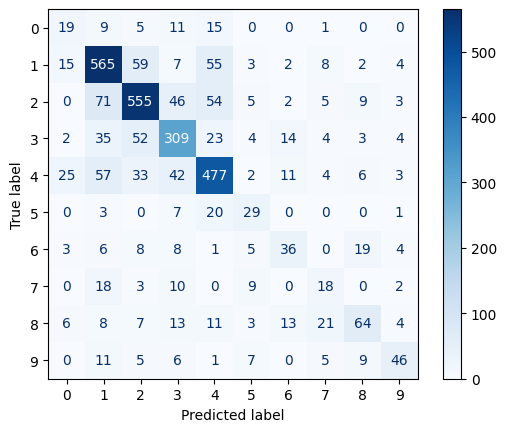


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       19        |        51        |
+-------+-----------------+------------------+
|   1   |       565       |       218        |
+-------+-----------------+------------------+
|   2   |       555       |       172        |
+-------+-----------------+------------------+
|   3   |       309       |       150        |
+-------+-----------------+------------------+
|   4   |       477       |       180        |
+-------+-----------------+------------------+
|   5   |       29        |        38        |
+-------+-----------------+------------------+
|   6   |       36        |        42        |
+-------+-----------------+------------------+
|   7   |       18        |        48        |
+-------+-----------------+------------------+
|   8   |       64        |        48        |
+-------+-----------------+------------------+
|   9   |    

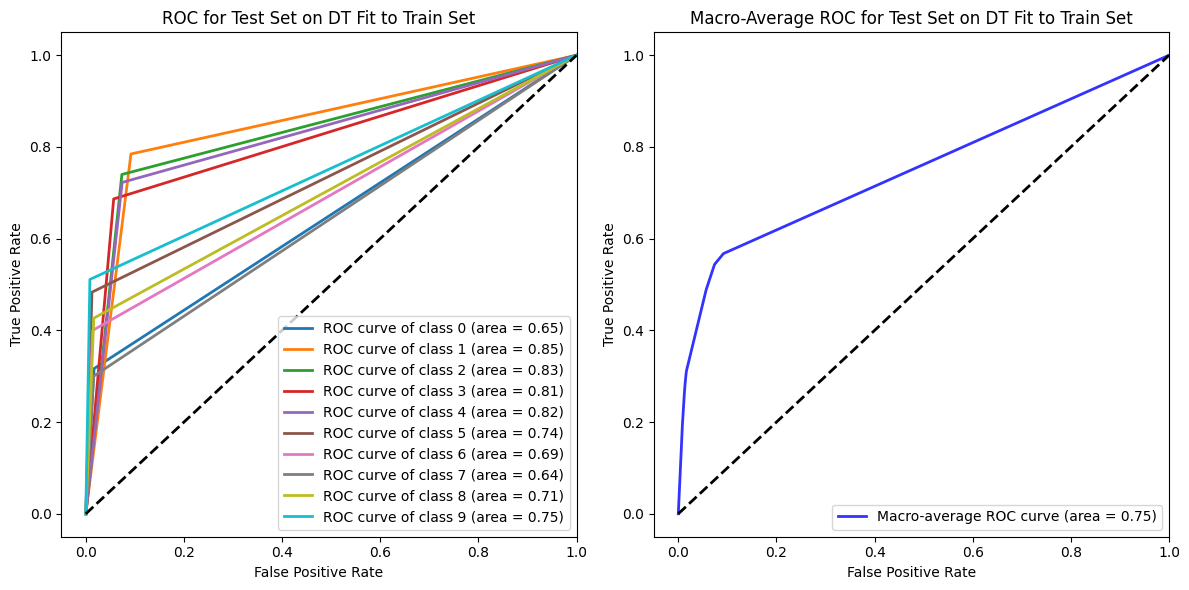

In [ ]:
# predictions using test set
y_pred_test = tree_clf_og.predict(x_test)
# probabilities using test set
y_prob_test = tree_clf_og.predict_proba(x_test)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_og_test = label_binarize(y_test, classes = classes)
y_pred_bin_og_test = label_binarize(y_pred_test, classes = classes)

# Call functions for evaluation
display_cf_report(y_test, y_pred_test)
display_TPR_FPR(y_test, y_pred_test)
plot_confusion_matrix(y_test, y_pred_test, classes)
list_TP_FP(y_test_bin_og_test, y_pred_bin_og_test)
plot_roc_curves(y_test_bin_og_test, y_prob_test, "ROC for Test Set on DT Fit to Train Set", "Macro-Average ROC for Test Set on DT Fit to Train Set")

#### **Conclusions**

#### **Comparing the Difference in Metrics on Train vs Test Data**

In [ ]:
display_accuracies(tree_clf_og, x_train, y_train, x_test, y_test)

Accuracy on training set: 100.00%
Accuracy on testing set: 68.54%
Difference: 31.46%


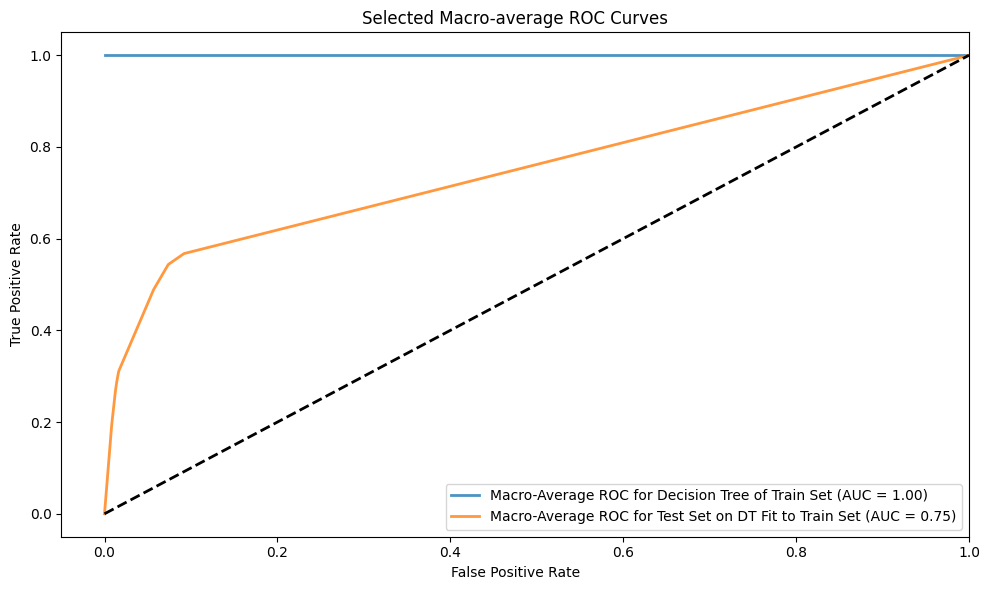

In [ ]:
plot_selected_roc_curves(['Macro-Average ROC for Test Set on DT Fit to Train Set', 'Macro-Average ROC for Decision Tree of Train Set'])

#### **Does the decision tree generalize well to new data? How do you tell?**

* The significant difference in accuracy between the training set (100.00%) and the testing set (68.54%) with a gap of 31.46% suggests that the decision tree model does not generalize well to new data.
* Generalization refers to the model's ability to adapt properly to new, previously unseen data, drawn from the same distribution as the one used to create the model.
* The key to identifying good generalization is not just high performance on the training data, but consistent performance across both training and testing data. The significant performance discrepancy here as seen in the previous macro average ROC curves, as well as the other metrics is a clear indicator that the model is overfitting the training data and not generalizing well to new data.
  * Overfitting occurs when a model learns the details and noise in the training data to the extent that it negatively impacts the performance of the model on new data.
* A well-generalized model should have comparable performance on both training and testing sets, indicating that it has learned the underlying patterns in the data, rather than just memorizing the training data.
* To improve the model's generalization, techniques like pruning the decision tree, using cross-validation to tune hyperparameters, or trying more complex models like Random Forests which are less prone to overfitting.

## **Training and Testing on Preprocessed Dataset with Gaussian Blur and Adaptive Thresholding**

### **Decision Tree on Processed Train Set**

#### **Make Decision Tree using Processed Train Set**

In [ ]:
tree_clf_gb = DecisionTreeClassifier(random_state=42)
tree_clf_gb.fit(processed_x_train, y_train)

#### **Accuracy of Decision Tree on Processed Train Set & Processed Test Set**

The accuracy here is 1.0 or 100% as the decision tree has not been regularized, (i.e., its hyper-parameters have not been altered to account for overfitting). As a result, the tree structure adapts itself to the training data, fitting it very closely, if not perfectly.

In [ ]:
display_accuracies(tree_clf_gb, processed_x_train, y_train, processed_x_test, y_test)

# **Tuning Hyper Parameters to Avoid Overfitting**

## **Pre Hyper Parameter Optimization: Min samples split, 	Min samples leaf & Max depth**

* This is done by maximizing the min_* hyper-parameters and minimizing the max_* hyper-parameters in order to regularize the model.
* That is, we minimized maximum depth of the tree and maximized minimum samples split and minimum samples leaf.
* Since the search field was too huge to try every single combination of a range of hyper parameter values, we tuned one hyper parameter first, then tuned 2 then tuned 3 hyper parameters choosing values that gave high accuries with lowest differences between train and test accuracies.

* When picking the optimal parameter values, there is a tradeoff between high accuracy and low difference between train and test. This trade-off is crucial for balancing model performance with its ability to generalize.
1. Maximizing Splitting criteria: Reducing the min_samples_split from 250 to 40 gradually improved the training score but also increased the gap between training and test scores. A lower min_samples_split allows the tree to create more complex patterns, which can lead to overfitting.
2. Maximizing Minimal number of instances permissible per leaf: As the min_samples_leaf decreased, the training score generally improved, but so did the difference between training and test scores. This parameter controls the minimum number of samples a leaf node must have, and a lower value can result in the tree capturing more detailed, specific patterns, potentially leading to overfitting.
3. Minimizing Depth of the tree: The max_depth parameter, which controls the depth of the tree, showed that a deeper tree (higher max_depth) generally resulted in better training performance but also increased the risk of overfitting, as seen in the larger differences between training and test scores.

### **Helper Functions**

#### **Function to Try 1 Hyper Parameter**

In [ ]:
def tuning1Param(clf_class, train, test, y_train, y_test, param, values):
    results = []
    for value in values:
        # Use a dictionary to set the parameter dynamically
        params = {param: value, 'random_state': 42}
        clf = clf_class(**params)
        clf.fit(train, y_train)
        train_score = clf.score(train, y_train) * 100
        test_score = clf.score(test, y_test) * 100
        difference = train_score - test_score
        results.append([value, train_score, test_score, difference])

    df = pd.DataFrame(results, columns=[param, "Train Score", "Test Score", "Difference"])
    print(df)

#### **Function to Try 2 Hyper Parameters**

In [ ]:
def tuning2Params(clf_class, train, test, y_train, y_test, param1, values1, param2, values2):
    results = []
    for value1, value2 in zip(values1, values2):
        # Use a dictionary to set parameters dynamically
        params = {param1: value1, param2: value2, 'random_state': 42}
        clf = clf_class(**params)
        clf.fit(train, y_train)
        train_score = clf.score(train, y_train) * 100
        test_score = clf.score(test, y_test) * 100
        difference = train_score - test_score
        results.append([value1, value2, train_score, test_score, difference])

    # Create DataFrame with results
    df = pd.DataFrame(results, columns=[param1, param2, "Train Score", "Test Score", "Difference"])
    print(df)

#### **Function to Try all 3 Hyper Parameters**

In [ ]:
train_scores = []
test_scores = []
differences = []
def append_accuracies(clf, x_train, y_train, x_test, y_test):
    train_score = clf.score(x_train,y_train)*100
    test_score = clf.score(x_test,y_test)*100
    difference = train_score - test_score
    train_scores.append(train_score)
    test_scores.append(test_score)
    differences.append(difference)

In [ ]:
def tuning(clf_class, train, test, y_train, y_test, min_samples_split, min_samples_leaf, max_depth):
    results = []
    for i in range(len(min_samples_split)):
        params = {
            'random_state': 42,
            'min_samples_split': min_samples_split[i],
            'min_samples_leaf': min_samples_leaf[i],
            'max_depth': max_depth[i]
        }
        clf = clf_class(**params)
        clf.fit(train, y_train)
        append_accuracies(clf, train, y_train, test, y_test)
        results.append([min_samples_split[i], min_samples_leaf[i], max_depth[i], train_scores[-1], test_scores[-1], differences[-1]])

    df = pd.DataFrame(results, columns=["Min Split", "Min Leaf", "Max Depth", "Train Score", "Test Score", "Difference"])
    print(df)

### **Tuning 1 Hyper Parameter: Trying Different Values for Min Samples Split**

* Trying a range of values for minimum number of samples to split and picking the "best" value which is a tradeoff between how high the accuracies are and how low the differences between the train and test accuracies.

In [ ]:
values = [40, 45, 50, 60, 65, 100, 150, 250]
tuning1Param(DecisionTreeClassifier, x_train, x_test, y_train, y_test, "min_samples_split", values)

   min_samples_split  Train Score  Test Score  Difference
0                 40    90.319917   67.475728   22.844189
1                 45    89.607843   68.187702   21.420141
2                 50    89.050568   68.187702   20.862865
3                 60    87.481940   67.055016   20.426924
4                 65    86.470588   66.763754   19.706834
5                100    83.601651   66.860841   16.740810
6                150    78.544892   65.728155   12.816736
7                250    74.375645   62.912621   11.463024


### **Tuning 2 Hyper Parameters: Trying Different Values for Min Samples Split & Min Sample Split**

In [ ]:
values1 = [150,150,150,150,150,150,150,150,150,150,150,250,200]
values2 = [80,60,45,40,35,30,25,20,32,34,37, 34, 34]

tuning2Params(DecisionTreeClassifier, x_train, x_test, y_train, y_test, "min_samples_split", values1, "min_samples_leaf", values2)

    min_samples_split  min_samples_leaf  Train Score  Test Score  Difference
0                 150                80    73.034056   64.304207    8.729849
1                 150                60    74.066047   64.822006    9.244041
2                 150                45    75.036120   65.889968    9.146152
3                 150                40    75.294118   66.278317    9.015800
4                 150                35    75.490196   65.792880    9.697316
5                 150                30    75.902993   66.245955    9.657038
6                 150                25    76.480908   65.987055   10.493853
7                 150                20    76.800826   65.954693   10.846133
8                 150                32    75.861713   66.148867    9.712846
9                 150                34    75.552116   65.922330    9.629785
10                150                37    75.428277   65.469256    9.959021
11                250                34    72.260062   63.754045    8.506017

### **Tuning all Hyper Parameters: Trying Different Values for all 3 Hyper Parameters**

In [ ]:
min_samples_splits = [150, 150, 150, 150, 150, 130, 130, 130, 120, 100, 100]
min_samples_leafs = [34, 34, 34, 34, 34, 32, 30, 28, 30, 30, 25]
max_depths = [5, 7, 8, 9, 10, 7, 7, 7, 7, 7, 7]
tuning(DecisionTreeClassifier, x_train, x_test, y_train, y_test, min_samples_splits, min_samples_leafs, max_depths)

    Min Split  Min Leaf  Max Depth  Train Score  Test Score  Difference
0         150        34          5    59.576883   59.741100   -0.164217
1         150        34          7    69.814241   63.883495    5.930746
2         150        34          8    72.569659   64.012945    8.556714
3         150        34          9    74.809082   64.789644   10.019438
4         150        34         10    75.438596   65.825243    9.613354
5         130        32          7    70.763674   64.919094    5.844580
6         130        30          7    70.763674   65.016181    5.747493
7         130        28          7    70.856553   64.271845    6.584708
8         120        30          7    71.393189   65.598706    5.794483
9         100        30          7    72.910217   66.019417    6.890799
10        100        25          7    73.188854   65.436893    7.751961


### **Picking Optimal Hyper Parameters**

#### **Optimal Parameters on Original Dataset w/out Preprocessing**

In [ ]:
tree_clf_op = DecisionTreeClassifier(random_state=42, min_samples_split=100, min_samples_leaf=25, max_depth=7)
tree_clf_op.fit(x_train, y_train)
display_accuracies(tree_clf_op, x_train, y_train, x_test, y_test)

Accuracy on training set: 73.19%
Accuracy on testing set: 65.44%
Difference: 7.75%



Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.66      0.53       210
           1       0.65      0.80      0.71      2220
           2       0.73      0.73      0.73      2250
           3       0.86      0.74      0.79      1410
           4       0.86      0.79      0.82      1980
           5       0.69      0.41      0.52       210
           6       0.54      0.74      0.62       360
           7       0.74      0.53      0.62       240
           8       0.85      0.55      0.67       540
           9       0.66      0.59      0.62       270

    accuracy                           0.73      9690
   macro avg       0.70      0.65      0.67      9690
weighted avg       0.75      0.73      0.73      9690

True Positive Rate: [0.66190476 0.7972973  0.73288889 0.73617021 0.78737374 0.41428571
 0.73611111 0.53333333 0.55       0.59259259]
False Positive Rate: [0.0185654  0.13012048 0.08010753 0.01992754 0.03242542 0.0041

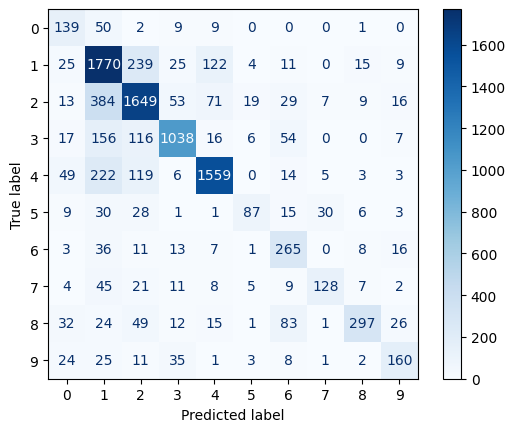


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       139       |       176        |
+-------+-----------------+------------------+
|   1   |      1770       |       972        |
+-------+-----------------+------------------+
|   2   |      1649       |       596        |
+-------+-----------------+------------------+
|   3   |      1038       |       165        |
+-------+-----------------+------------------+
|   4   |      1559       |       250        |
+-------+-----------------+------------------+
|   5   |       87        |        39        |
+-------+-----------------+------------------+
|   6   |       265       |       223        |
+-------+-----------------+------------------+
|   7   |       128       |        44        |
+-------+-----------------+------------------+
|   8   |       297       |        51        |
+-------+-----------------+------------------+
|   9   |    

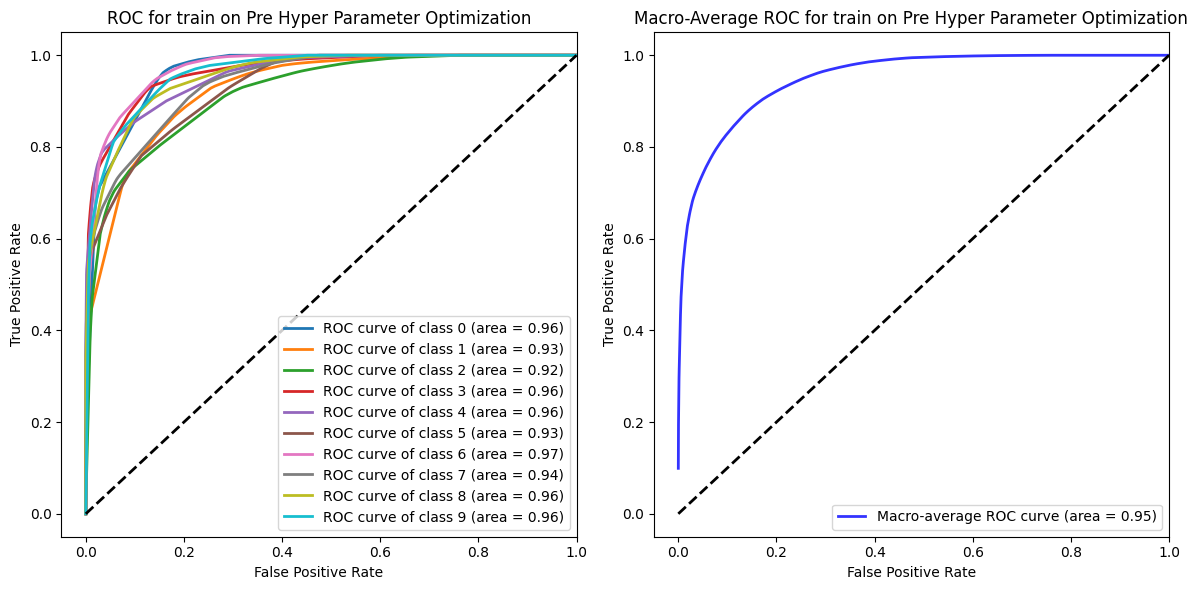

In [ ]:
# predictions using test set
y_pred_train_op = tree_clf_op.predict(x_train)
# probabilities using test set
y_prob_train_op = tree_clf_op.predict_proba(x_train)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_op_train = label_binarize(y_train, classes = classes)
y_pred_bin_op_train = label_binarize(y_pred_train_op, classes = classes)

# Call functions for evaluation
display_cf_report(y_train, y_pred_train_op)
display_TPR_FPR(y_train, y_pred_train_op)
plot_confusion_matrix(y_train, y_pred_train_op, classes)
list_TP_FP(y_test_bin_op_train, y_pred_bin_op_train)
plot_roc_curves(y_test_bin_op_train, y_prob_train_op, "ROC for train on Pre Hyper Parameter Optimization", "Macro-Average ROC for train on Pre Hyper Parameter Optimization")


Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.35      0.26        60
           1       0.63      0.81      0.71       720
           2       0.70      0.71      0.70       750
           3       0.70      0.59      0.64       450
           4       0.76      0.70      0.73       660
           5       0.57      0.22      0.31        60
           6       0.31      0.38      0.34        90
           7       0.16      0.07      0.09        60
           8       0.83      0.41      0.55       150
           9       0.59      0.50      0.54        90

    accuracy                           0.65      3090
   macro avg       0.54      0.47      0.49      3090
weighted avg       0.66      0.65      0.65      3090

True Positive Rate: [0.35       0.81111111 0.70533333 0.59333333 0.70151515 0.21666667
 0.37777778 0.06666667 0.41333333 0.5       ]
False Positive Rate: [0.02640264 0.14472574 0.09871795 0.04356061 0.06131687 0.0033

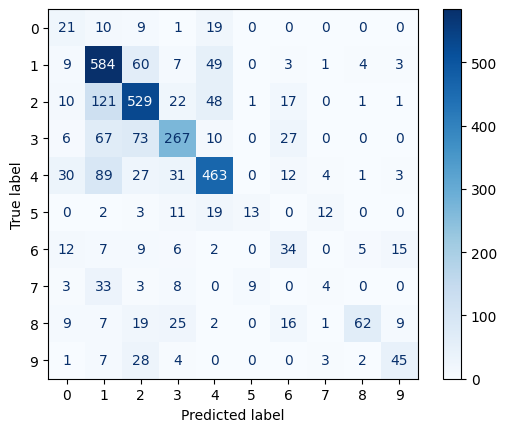


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       21        |        80        |
+-------+-----------------+------------------+
|   1   |       584       |       343        |
+-------+-----------------+------------------+
|   2   |       529       |       231        |
+-------+-----------------+------------------+
|   3   |       267       |       115        |
+-------+-----------------+------------------+
|   4   |       463       |       149        |
+-------+-----------------+------------------+
|   5   |       13        |        10        |
+-------+-----------------+------------------+
|   6   |       34        |        75        |
+-------+-----------------+------------------+
|   7   |        4        |        21        |
+-------+-----------------+------------------+
|   8   |       62        |        13        |
+-------+-----------------+------------------+
|   9   |    

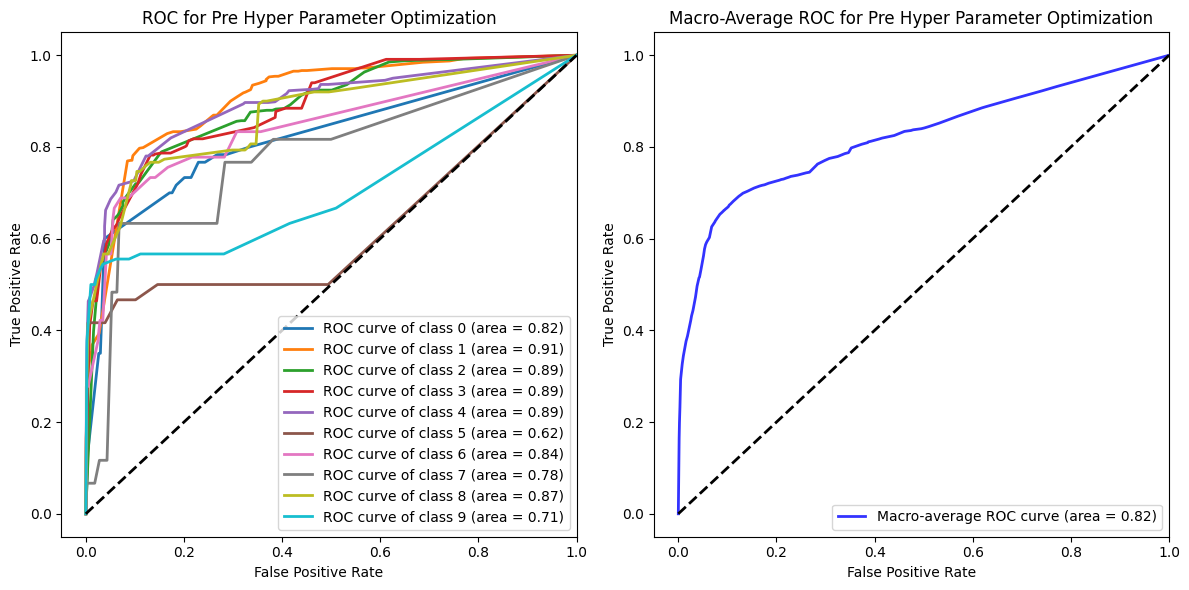

In [ ]:
# predictions using test set
y_pred_test_op = tree_clf_op.predict(x_test)
# probabilities using test set
y_prob_test_op = tree_clf_op.predict_proba(x_test)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_op_test = label_binarize(y_test, classes = classes)
y_pred_bin_op_test = label_binarize(y_pred_test_op, classes = classes)

# Call functions for evaluation
display_cf_report(y_test, y_pred_test_op)
display_TPR_FPR(y_test, y_pred_test_op)
plot_confusion_matrix(y_test, y_pred_test_op, classes)
list_TP_FP(y_test_bin_op_test, y_pred_bin_op_test)
plot_roc_curves(y_test_bin_op_test, y_prob_test_op, "ROC for Pre Hyper Parameter Optimization", "Macro-Average ROC for Pre Hyper Parameter Optimization")

#### **Optimal Parameters on Processed Dataset**

In [ ]:
tree_clf_gb1 = DecisionTreeClassifier(random_state=42, min_samples_split=100, min_samples_leaf=25, max_depth=7)
tree_clf_gb1.fit(processed_x_train, y_train)
display_accuracies(tree_clf_gb1, processed_x_train, y_train, processed_x_test, y_test)

Accuracy on training set: 83.45%
Accuracy on testing set: 81.33%
Difference: 2.12%



Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       210
           1       0.82      0.89      0.86      2220
           2       0.84      0.83      0.84      2250
           3       0.72      0.77      0.75      1410
           4       0.90      0.88      0.89      1980
           5       0.85      0.54      0.66       210
           6       0.83      0.74      0.78       360
           7       0.78      0.75      0.76       240
           8       0.86      0.82      0.84       540
           9       0.84      0.62      0.71       270

    accuracy                           0.83      9690
   macro avg       0.82      0.76      0.78      9690
weighted avg       0.83      0.83      0.83      9690

True Positive Rate: [0.76666667 0.89099099 0.82977778 0.77163121 0.88282828 0.54285714
 0.73611111 0.75       0.81666667 0.61851852]
False Positive Rate: [0.007173   0.0562249  0.0469086  0.05072464 0.02529183 0.0021

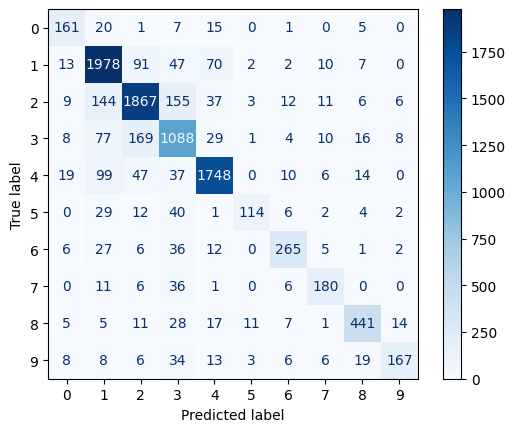


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       161       |        68        |
+-------+-----------------+------------------+
|   1   |      1978       |       420        |
+-------+-----------------+------------------+
|   2   |      1867       |       349        |
+-------+-----------------+------------------+
|   3   |      1088       |       420        |
+-------+-----------------+------------------+
|   4   |      1748       |       195        |
+-------+-----------------+------------------+
|   5   |       114       |        20        |
+-------+-----------------+------------------+
|   6   |       265       |        54        |
+-------+-----------------+------------------+
|   7   |       180       |        51        |
+-------+-----------------+------------------+
|   8   |       441       |        72        |
+-------+-----------------+------------------+
|   9   |    

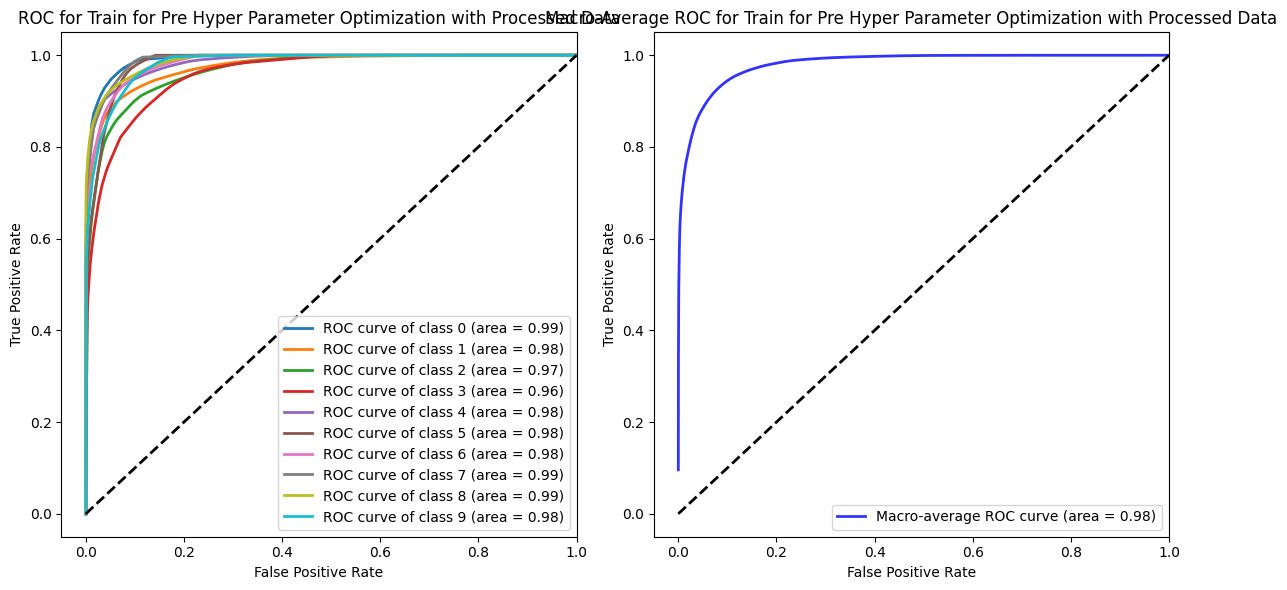

In [ ]:
# predictions using test set
y_pred_train_gb1 = tree_clf_gb1.predict(processed_x_train)
# probabilities using test set
y_prob_train_gb1 = tree_clf_gb1.predict_proba(processed_x_train)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_gb1_train = label_binarize(y_train, classes = classes)
y_pred_bin_gb1_train = label_binarize(y_pred_train_gb1, classes = classes)

# Call functions for evaluation
display_cf_report(y_train, y_pred_train_gb1)
display_TPR_FPR(y_train, y_pred_train_gb1)
plot_confusion_matrix(y_train, y_pred_train_gb1, classes)
list_TP_FP(y_test_bin_gb1_train, y_pred_bin_gb1_train)
plot_roc_curves(y_test_bin_gb1_train, y_prob_train_gb1, "ROC for Train for Pre Hyper Parameter Optimization with Processed Data", "Macro-Average ROC for Train for Pre Hyper Parameter Optimization with Processed Data")


Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.65      0.55        60
           1       0.85      0.90      0.87       720
           2       0.83      0.89      0.86       750
           3       0.66      0.66      0.66       450
           4       0.88      0.81      0.84       660
           5       0.83      0.72      0.77        60
           6       0.76      0.57      0.65        90
           7       0.82      0.88      0.85        60
           8       0.79      0.69      0.74       150
           9       0.86      0.69      0.77        90

    accuracy                           0.81      3090
   macro avg       0.77      0.75      0.75      3090
weighted avg       0.81      0.81      0.81      3090

True Positive Rate: [0.65       0.89722222 0.88933333 0.65777778 0.80757576 0.71666667
 0.56666667 0.88333333 0.69333333 0.68888889]
False Positive Rate: [0.01419142 0.04767932 0.06025641 0.05681818 0.03045267 0.0029

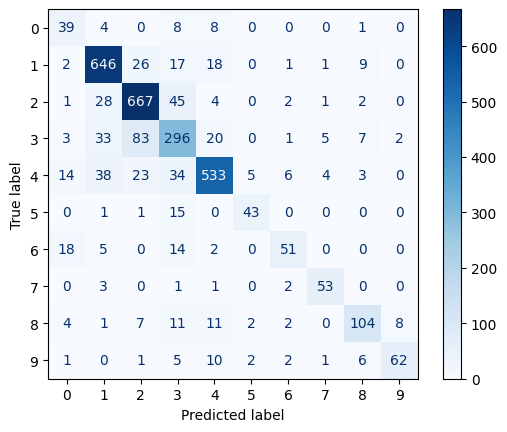


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       39        |        43        |
+-------+-----------------+------------------+
|   1   |       646       |       113        |
+-------+-----------------+------------------+
|   2   |       667       |       141        |
+-------+-----------------+------------------+
|   3   |       296       |       150        |
+-------+-----------------+------------------+
|   4   |       533       |        74        |
+-------+-----------------+------------------+
|   5   |       43        |        9         |
+-------+-----------------+------------------+
|   6   |       51        |        16        |
+-------+-----------------+------------------+
|   7   |       53        |        12        |
+-------+-----------------+------------------+
|   8   |       104       |        28        |
+-------+-----------------+------------------+
|   9   |    

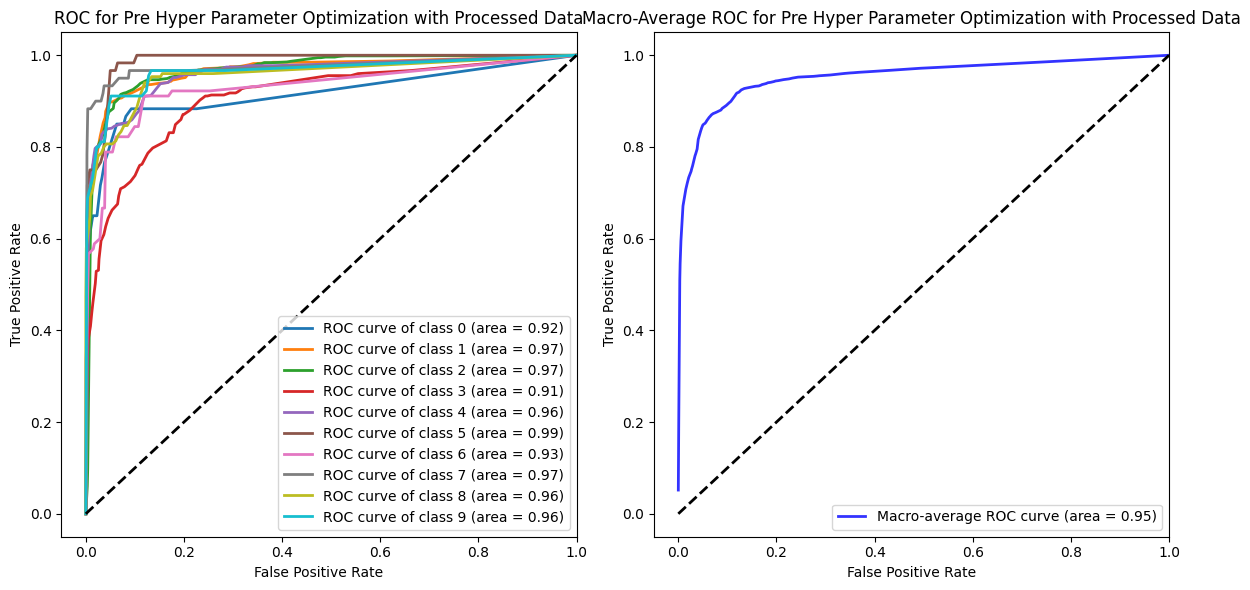

In [ ]:
# predictions using test set
y_pred_test_gb1 = tree_clf_gb1.predict(processed_x_test)
# probabilities using test set
y_prob_test_gb1 = tree_clf_gb1.predict_proba(processed_x_test)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_gb1_test = label_binarize(y_test, classes = classes)
y_pred_bin_gb1_test = label_binarize(y_pred_test_gb1, classes = classes)

# Call functions for evaluation
display_cf_report(y_test, y_pred_test_gb1)
display_TPR_FPR(y_test, y_pred_test_gb1)
plot_confusion_matrix(y_test, y_pred_test_gb1, classes)
list_TP_FP(y_test_bin_gb1_test, y_pred_bin_gb1_test)
plot_roc_curves(y_test_bin_gb1_test, y_prob_test_gb1, "ROC for Pre Hyper Parameter Optimization with Processed Data", "Macro-Average ROC for Pre Hyper Parameter Optimization with Processed Data")

#### **Conclusion**

* For the original dataset without preprocessing, the optimal parameters (min_samples_split=100, min_samples_leaf=25, max_depth=7) led to a training accuracy of 73.19% and testing accuracy of 65.44%, a 7.75% difference, showing a balance between model complexity and overfitting.
* For the preprocessed dataset, the same optimal parameters resulted in higher training (83.45%) and testing accuracy (81.33%), with a much lower difference of 2.12%, indicating a better generalization capability.
* Overall, preprocessing the dataset and fine-tuning the decision tree parameters resulted in a more accurate, robust, and generalizable model.

## **Post Hyper Parameter Optimization: Pruning Decision Trees**

- Another way to control the size of the tree so as to prevent the tree from overfitting is by using cost complexity pruning. It is parameterized by using effective alpha values.
- As the alpha increases, more nodes are pruned which in turn increases the impurity of its leaves.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, random_state=42)

In [ ]:
path = tree_clf_og.cost_complexity_pruning_path(X_train, Y_train)
# returns the effective alphas and the corresponding total leaf impurities
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
unique_alphas = sorted(list(set(ccp_alphas)), key = lambda x:float(x))

In [ ]:
clfs = []
for ccp_alpha in unique_alphas:
    # Training decision tree classifier with effective alphas
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, Y_train)
    clfs.append(clf)

- When the alpha value is 0 while keeping all the other parameters, the tree overfits, thus resulting in 100% training accuracy and 81.7% testing accuracy.

- We plot the below graph to check for maximum test accuracy value which in turn gives us the optimal alpha value.

Reference: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [ ]:
# Getting the accuracy for train and test when ran on the trained decision trees
train_scores = [clf.score(X_train, Y_train) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

In [ ]:
def accuracy_alpha_plot(unique_alphas, train_scores, test_scores):
  fig, ax = plt.subplots()
  ax.set_xlabel("alpha")
  ax.set_ylabel("accuracy")
  ax.set_title("Accuracy vs alpha for training and testing sets")
  ax.plot(unique_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
  ax.plot(unique_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
  ax.legend()
  plt.show()

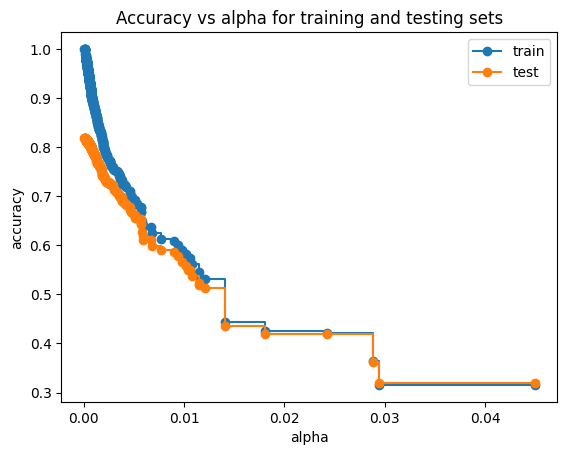

In [ ]:
accuracy_alpha_plot(unique_alphas, train_scores, test_scores)

- Over here we see that alpha value of 0.0028 gives the least difference between the accuracies of train and test sets and a maximum test accuracy.

# **Move 30% instances from original training set to test set**

## **Helper Functions**

### **Function to move 30/60% from Train to Test**

In [ ]:
def move_percent(x_train, y_train, x_test, y_test, percent):
  # Create a new training set and a test subset by moving 30% of instances to the test set
  test_size = 0.3 if percent == 30 else 0.6
  x_train, x_test_subset, y_train, y_test_subset = train_test_split(
      x_train, y_train, test_size=test_size, random_state=42)
  # Append the test subset to the original test set
  x_test = pd.concat([x_test, x_test_subset],  ignore_index=True)
  y_test = pd.concat([y_test, y_test_subset],  ignore_index=True)
  return x_train, y_train, x_test, y_test

## **Make Datasets**

In [ ]:
x_train_30, y_train_30, x_test_30, y_test_30 = move_percent(x_train, y_train, x_test, y_test,30)

In [ ]:
x_train_30p, y_train_30p, x_test_30p, y_test_30p = move_percent(processed_x_train, y_train, processed_x_test, y_test,30)

In [ ]:
print(x_train_30.shape)
print(y_train_30.shape)
print(x_test_30.shape)
print(y_test_30.shape)

(6783, 2304)
(6783, 1)
(5997, 2304)
(5997, 1)


## **Trying out top 3 alpha values for pruning**

In [ ]:
ccp_alphas = [0.0028, 0.0025, 0.0018]
tuning1Param(x_train_30, x_test_30, y_train_30, y_test_30, "ccp_alpha", ccp_alphas)

   ccp_alpha  Train Score  Test Score  Difference
0     0.0028    77.989090   69.151242    8.837848
1     0.0025    79.448622   69.551442    9.897179
2     0.0018    82.220257   71.335668   10.884589


As we can see the least difference is when alpha is 0.0028. This will be taken as the optimal value.

## **Classification Report of Optimized Hyper Parameters**

### **Data w/out Preprocessing**

In [ ]:
tree_clf_30 = DecisionTreeClassifier(random_state=42, min_samples_split=100, min_samples_leaf=25, max_depth=7)
tree_clf_30.fit(x_train_30, y_train_30)
display_accuracies(tree_clf_30, x_train_30, y_train_30, x_test_30, y_test_30)

Accuracy on training set: 73.91%
Accuracy on testing set: 66.32%
Difference: 7.59%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.72      0.78      0.75      1555
           2       0.72      0.75      0.74      1572
           3       0.84      0.73      0.78       984
           4       0.73      0.83      0.77      1393
           5       0.58      0.58      0.58       139
           6       0.67      0.70      0.68       260
           7       0.81      0.52      0.63       175
           8       0.79      0.71      0.75       382
           9       0.77      0.64      0.70       188

    accuracy                           0.74      6783
   macro avg       0.66      0.63      0.64      6783
weighted avg       0.73      0.74      0.73      6783

True Positive Rate: [0.         0.78199357 0.75254453 0.72662602 0.82555635 0.58273381
 0.70384615 0.52       0.71465969 0.64361702]
False Positive Rate: [0.         0.08990054 0.08635579 0.02414209 0.07959184 0.0088

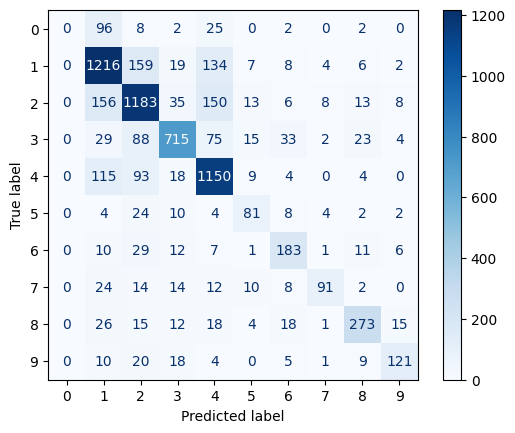


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |        0        |        0         |
+-------+-----------------+------------------+
|   1   |      1216       |       470        |
+-------+-----------------+------------------+
|   2   |      1183       |       450        |
+-------+-----------------+------------------+
|   3   |       715       |       140        |
+-------+-----------------+------------------+
|   4   |      1150       |       429        |
+-------+-----------------+------------------+
|   5   |       81        |        59        |
+-------+-----------------+------------------+
|   6   |       183       |        92        |
+-------+-----------------+------------------+
|   7   |       91        |        21        |
+-------+-----------------+------------------+
|   8   |       273       |        72        |
+-------+-----------------+------------------+
|   9   |    

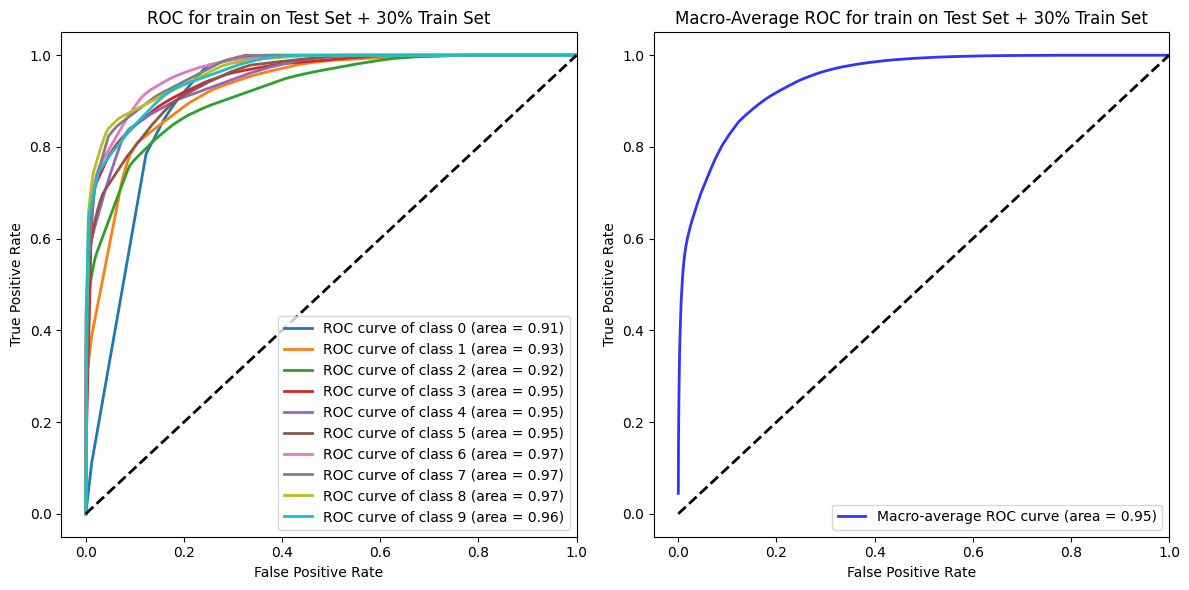

In [ ]:
# predictions using test set
y_pred_train30 = tree_clf_30.predict(x_train_30)
# probabilities using test set
y_prob_train30 = tree_clf_30.predict_proba(x_train_30)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_30_train = label_binarize(y_train_30, classes = classes)
y_pred_bin_30_train = label_binarize(y_pred_train30, classes = classes)

# Call functions for evaluation
display_cf_report(y_train_30, y_pred_train30)
display_TPR_FPR(y_train_30, y_pred_train30)
plot_confusion_matrix(y_train_30, y_pred_train30, classes)
list_TP_FP(y_test_bin_30_train, y_pred_bin_30_train)
plot_roc_curves(y_test_bin_30_train, y_prob_train30, "ROC for train on Test Set + 30% Train Set", "Macro-Average ROC for train on Test Set + 30% Train Set")


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.66      0.75      0.70      1385
           2       0.67      0.67      0.67      1428
           3       0.71      0.66      0.68       876
           4       0.64      0.75      0.69      1247
           5       0.58      0.53      0.56       131
           6       0.56      0.61      0.58       190
           7       0.62      0.29      0.39       125
           8       0.77      0.56      0.65       308
           9       0.66      0.51      0.57       172

    accuracy                           0.66      5997
   macro avg       0.59      0.53      0.55      5997
weighted avg       0.65      0.66      0.65      5997

True Positive Rate: [0.         0.7465704  0.66736695 0.6609589  0.74659182 0.53435115
 0.60526316 0.288      0.55844156 0.50581395]
False Positive Rate: [0.         0.11491761 0.10199168 0.0464753  0.11073684 0.0086

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


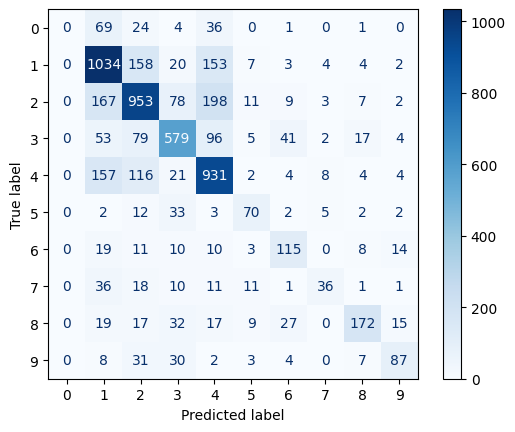


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |        0        |        0         |
+-------+-----------------+------------------+
|   1   |      1034       |       530        |
+-------+-----------------+------------------+
|   2   |       953       |       466        |
+-------+-----------------+------------------+
|   3   |       579       |       238        |
+-------+-----------------+------------------+
|   4   |       931       |       526        |
+-------+-----------------+------------------+
|   5   |       70        |        51        |
+-------+-----------------+------------------+
|   6   |       115       |        92        |
+-------+-----------------+------------------+
|   7   |       36        |        22        |
+-------+-----------------+------------------+
|   8   |       172       |        51        |
+-------+-----------------+------------------+
|   9   |    

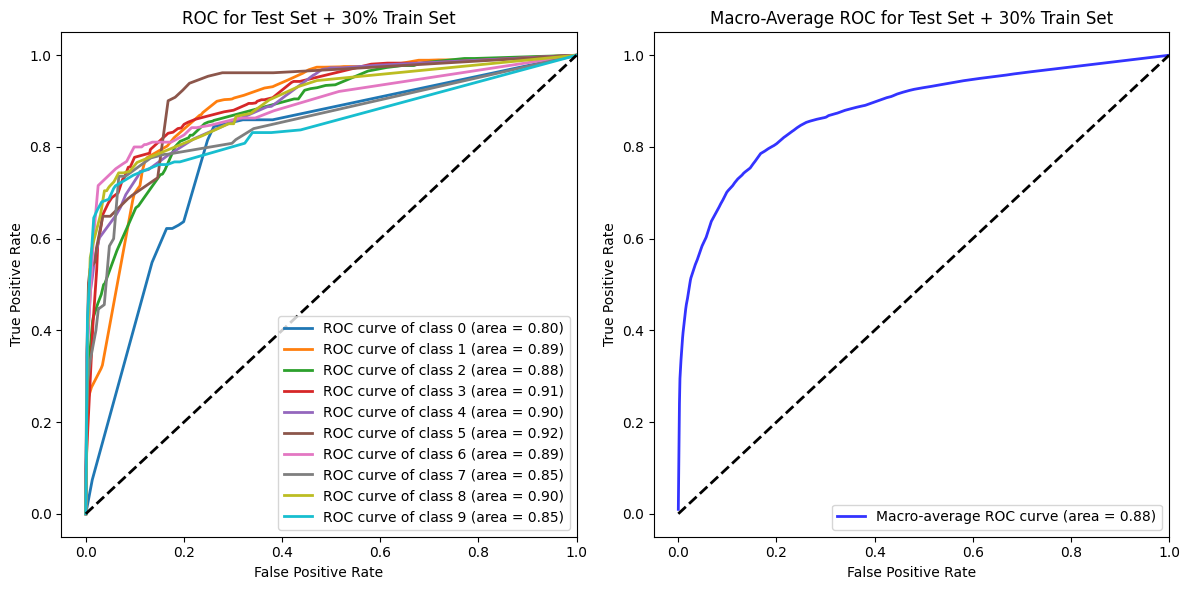

In [ ]:
# predictions using test set
y_pred_test30 = tree_clf_30.predict(x_test_30)
# probabilities using test set
y_prob_test30 = tree_clf_30.predict_proba(x_test_30)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_30_test = label_binarize(y_test_30, classes = classes)
y_pred_bin_30_test = label_binarize(y_pred_test30, classes = classes)

# Call functions for evaluation
display_cf_report(y_test_30, y_pred_test30)
display_TPR_FPR(y_test_30, y_pred_test30)
plot_confusion_matrix(y_test_30, y_pred_test30, classes)
list_TP_FP(y_test_bin_30_test, y_pred_bin_30_test)
plot_roc_curves(y_test_bin_30_test, y_prob_test30, "ROC for Test Set + 30% Train Set", "Macro-Average ROC for Test Set + 30% Train Set")

### **Data with Preprocessing**

In [ ]:
tree_clf_30p = DecisionTreeClassifier(random_state=42, min_samples_split=100, min_samples_leaf=25, max_depth=7)
tree_clf_30p.fit(x_train_30p, y_train_30)
display_accuracies(tree_clf_30p, x_train_30p, y_train_30, x_test_30p, y_test_30)

Accuracy on training set: 81.57%
Accuracy on testing set: 79.41%
Difference: 2.17%



Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.76       135
           1       0.88      0.85      0.87      1555
           2       0.82      0.80      0.81      1572
           3       0.66      0.77      0.71       984
           4       0.88      0.89      0.89      1393
           5       0.70      0.60      0.64       139
           6       0.70      0.73      0.71       260
           7       0.80      0.82      0.81       175
           8       0.91      0.84      0.87       382
           9       0.73      0.65      0.69       188

    accuracy                           0.82      6783
   macro avg       0.79      0.76      0.78      6783
weighted avg       0.82      0.82      0.82      6783

True Positive Rate: [0.67407407 0.84951768 0.79961832 0.77235772 0.89303661 0.5971223
 0.72692308 0.82285714 0.84293194 0.64893617]
False Positive Rate: [0.00225632 0.03404744 0.05162157 0.06673564 0.03135436 0.00541

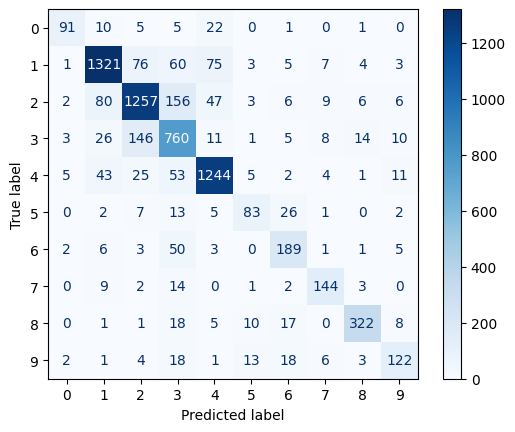


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       91        |        15        |
+-------+-----------------+------------------+
|   1   |      1321       |       178        |
+-------+-----------------+------------------+
|   2   |      1257       |       269        |
+-------+-----------------+------------------+
|   3   |       760       |       387        |
+-------+-----------------+------------------+
|   4   |      1244       |       169        |
+-------+-----------------+------------------+
|   5   |       83        |        36        |
+-------+-----------------+------------------+
|   6   |       189       |        82        |
+-------+-----------------+------------------+
|   7   |       144       |        36        |
+-------+-----------------+------------------+
|   8   |       322       |        33        |
+-------+-----------------+------------------+
|   9   |    

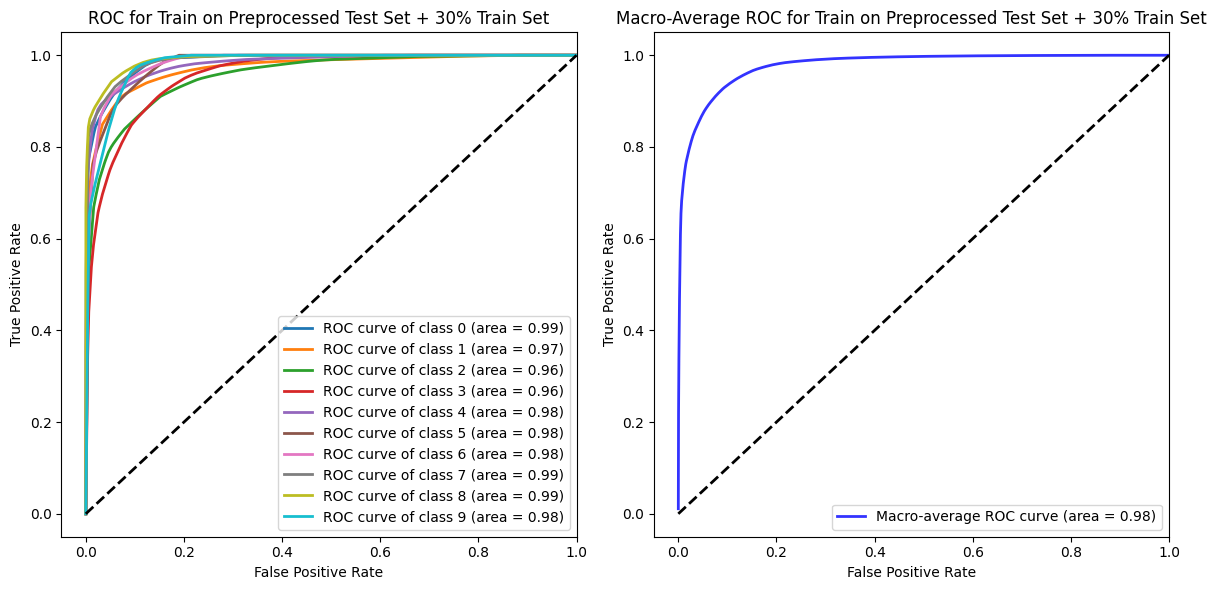

In [ ]:
# predictions using test set
y_pred_train30p = tree_clf_30p.predict(x_train_30p)
# probabilities using test set
y_prob_train30p = tree_clf_30p.predict_proba(x_train_30p)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_30_trainp = label_binarize(y_train_30, classes = classes)
y_pred_bin_30_trainp = label_binarize(y_pred_train30p, classes = classes)

# Call functions for evaluation
display_cf_report(y_train_30, y_pred_train30p)
display_TPR_FPR(y_train_30, y_pred_train30p)
plot_confusion_matrix(y_train_30, y_pred_train30p, classes)
list_TP_FP(y_test_bin_30_trainp, y_pred_bin_30_trainp)
plot_roc_curves(y_test_bin_30_trainp, y_prob_train30p, "ROC for Train on Preprocessed Test Set + 30% Train Set", "Macro-Average ROC for Train on Preprocessed Test Set + 30% Train Set")


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.58      0.67       135
           1       0.88      0.80      0.84      1385
           2       0.81      0.83      0.82      1428
           3       0.66      0.73      0.69       876
           4       0.85      0.87      0.86      1247
           5       0.60      0.65      0.62       131
           6       0.54      0.68      0.60       190
           7       0.78      0.86      0.81       125
           8       0.84      0.76      0.80       308
           9       0.71      0.70      0.70       172

    accuracy                           0.79      5997
   macro avg       0.75      0.74      0.74      5997
weighted avg       0.80      0.79      0.80      5997

True Positive Rate: [0.57777778 0.8        0.82563025 0.7260274  0.87169206 0.64885496
 0.67894737 0.856      0.75649351 0.69767442]
False Positive Rate: [0.0035824  0.0320902  0.05909389 0.06287834 0.03936842 0.0095

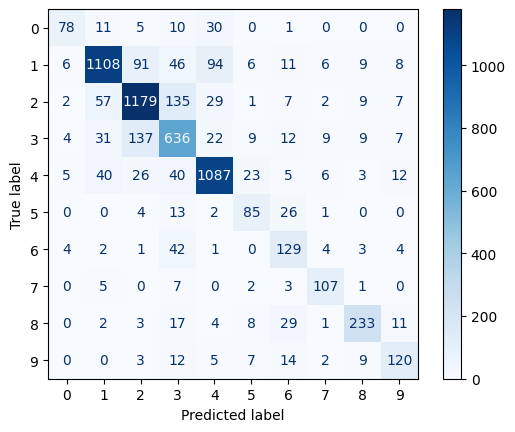


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       78        |        21        |
+-------+-----------------+------------------+
|   1   |      1108       |       148        |
+-------+-----------------+------------------+
|   2   |      1179       |       270        |
+-------+-----------------+------------------+
|   3   |       636       |       322        |
+-------+-----------------+------------------+
|   4   |      1087       |       187        |
+-------+-----------------+------------------+
|   5   |       85        |        56        |
+-------+-----------------+------------------+
|   6   |       129       |       108        |
+-------+-----------------+------------------+
|   7   |       107       |        31        |
+-------+-----------------+------------------+
|   8   |       233       |        43        |
+-------+-----------------+------------------+
|   9   |    

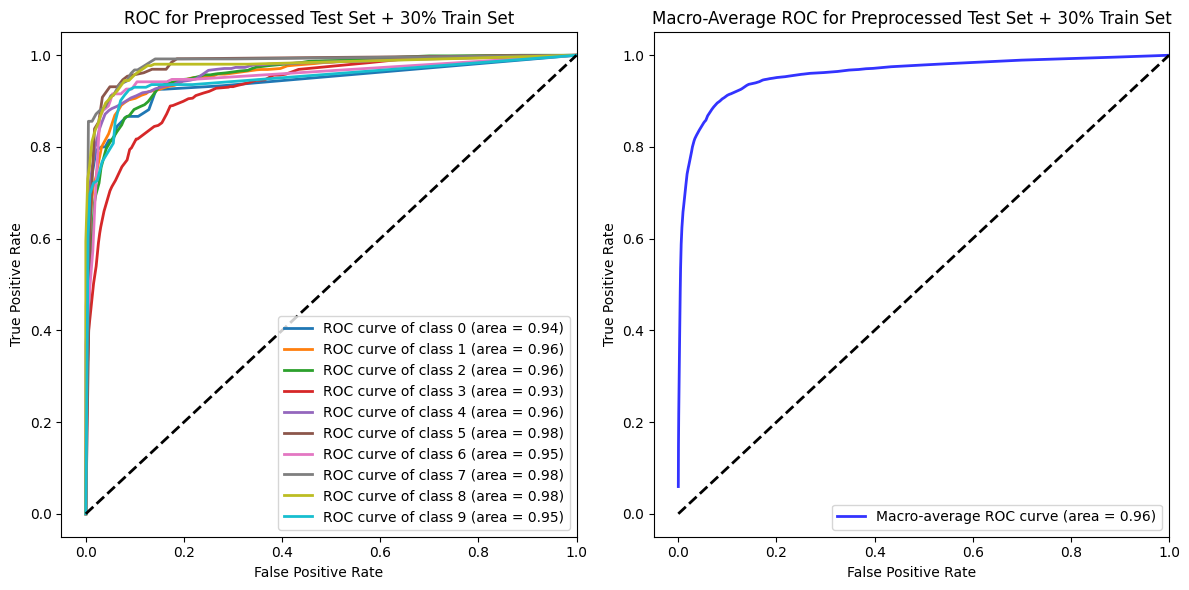

In [ ]:
# predictions using test set
y_pred_test30p = tree_clf_30p.predict(x_test_30p)
# probabilities using test set
y_prob_test30p = tree_clf_30p.predict_proba(x_test_30p)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_30_testp = label_binarize(y_test_30, classes = classes)
y_pred_bin_30_testp = label_binarize(y_pred_test30p, classes = classes)

# Call functions for evaluation
display_cf_report(y_test_30, y_pred_test30p)
display_TPR_FPR(y_test_30, y_pred_test30p)
plot_confusion_matrix(y_test_30, y_pred_test30p, classes)
list_TP_FP(y_test_bin_30_testp, y_pred_bin_30_testp)
plot_roc_curves(y_test_bin_30_testp, y_prob_test30p, "ROC for Preprocessed Test Set + 30% Train Set", "Macro-Average ROC for Preprocessed Test Set + 30% Train Set")

## **Conclusions**

* Preprocessing significantly improves model generalization: with 30% of data moved to the test set, preprocessing yields an 81.57% training and 79.41% testing accuracy, reducing overfitting (difference of 2.17%).

**Effects of Overfitting:**
* Without Preprocessing: The model tends to overfit more, as indicated by the higher differences between training and testing accuracies. This implies the model is learning some training-specific noise or details that don't generalize well.
* With Preprocessing: Preprocessing helps the model focus on more generalized features, reducing the risk of overfitting, as seen in the smaller differences between training and testing accuracies.

# **Move 60% instances from original training set to test set**

## **Make Datasets**

In [ ]:
x_train_60, y_train_60, x_test_60, y_test_60 = move_percent(x_train, y_train, x_test, y_test, 60)

In [ ]:
x_train_60p, y_train_60p, x_test_60p, y_test_60p = move_percent(processed_x_train, y_train, processed_x_test, y_test,60)

In [ ]:
print(x_train_60.shape)
print(y_train_60.shape)
print(x_test_60.shape)
print(y_test_60.shape)

(3876, 2304)
(3876, 1)
(8904, 2304)
(8904, 1)


## **Trying out top 3 alpha values for pruning**

In [ ]:
ccp_alphas = [0.0028, 0.0025, 0.0018]
tuning1Param(x_train_60, x_test_60, y_train_60, y_test_60, "ccp_alpha", ccp_alphas)

   ccp_alpha  Train Score  Test Score  Difference
0     0.0028    80.546956   68.283917   12.263038
1     0.0025    82.481940   68.744385   13.737556
2     0.0018    86.635707   70.226864   16.408843


* Similar to 30% dataset, 0.0028 gives the least difference between train and test set accuracies.

## **Classification Report of Optimized Hyper Parameters**

### **Data w/out Preprocessing**

In [ ]:
tree_clf_60 = DecisionTreeClassifier(random_state=42, min_samples_split=100, min_samples_leaf=25, max_depth=7)
tree_clf_60.fit(x_train_60, y_train_60)
display_accuracies(tree_clf_60, x_train_60, y_train_60, x_test_60, y_test_60)

Accuracy on training set: 70.05%
Accuracy on testing set: 62.98%
Difference: 7.06%



Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.38      0.33        76
           1       0.71      0.76      0.74       884
           2       0.66      0.77      0.71       892
           3       0.73      0.80      0.76       544
           4       0.88      0.72      0.80       829
           5       0.46      0.15      0.22        81
           6       0.59      0.60      0.60       141
           7       0.37      0.35      0.36        96
           8       0.64      0.59      0.61       222
           9       0.53      0.25      0.34       111

    accuracy                           0.70      3876
   macro avg       0.59      0.54      0.55      3876
weighted avg       0.70      0.70      0.70      3876

True Positive Rate: [0.38157895 0.76357466 0.7735426  0.79595588 0.7225573  0.14814815
 0.60283688 0.35416667 0.58558559 0.25225225]
False Positive Rate: [0.01921053 0.09191176 0.1169571  0.04771909 0.02559895 0.0036

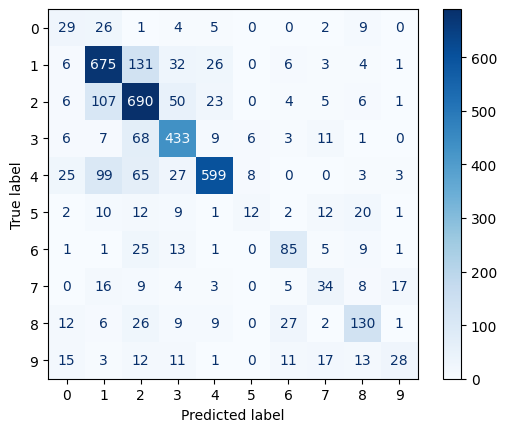


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       29        |        73        |
+-------+-----------------+------------------+
|   1   |       675       |       275        |
+-------+-----------------+------------------+
|   2   |       690       |       349        |
+-------+-----------------+------------------+
|   3   |       433       |       159        |
+-------+-----------------+------------------+
|   4   |       599       |        78        |
+-------+-----------------+------------------+
|   5   |       12        |        14        |
+-------+-----------------+------------------+
|   6   |       85        |        58        |
+-------+-----------------+------------------+
|   7   |       34        |        57        |
+-------+-----------------+------------------+
|   8   |       130       |        73        |
+-------+-----------------+------------------+
|   9   |    

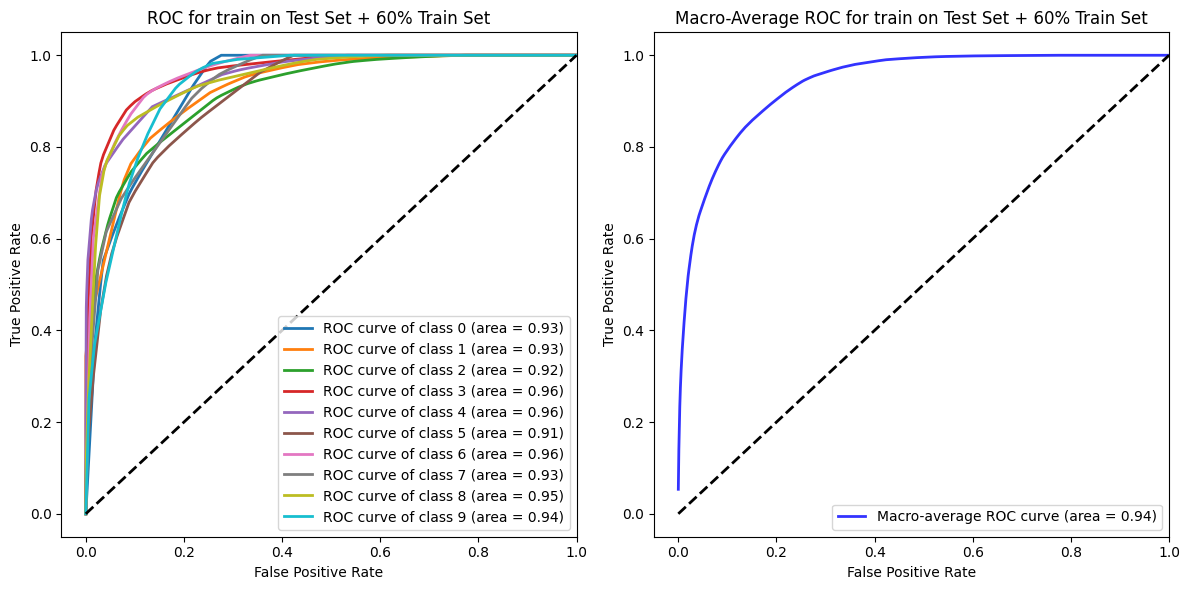

In [ ]:
# predictions using test set
y_pred_train60 = tree_clf_60.predict(x_train_60)
# probabilities using test set
y_prob_train60 = tree_clf_60.predict_proba(x_train_60)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_60_train = label_binarize(y_train_60, classes = classes)
y_pred_bin_60_train = label_binarize(y_pred_train60, classes = classes)

# Call functions for evaluation
display_cf_report(y_train_60, y_pred_train60)
display_TPR_FPR(y_train_60, y_pred_train60)
plot_confusion_matrix(y_train_60, y_pred_train60, classes)
list_TP_FP(y_test_bin_60_train, y_pred_bin_60_train)
plot_roc_curves(y_test_bin_60_train, y_prob_train60, "ROC for train on Test Set + 60% Train Set", "Macro-Average ROC for train on Test Set + 60% Train Set")


Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.35      0.30       194
           1       0.65      0.74      0.69      2056
           2       0.59      0.71      0.64      2108
           3       0.68      0.65      0.66      1316
           4       0.81      0.64      0.72      1811
           5       0.55      0.14      0.22       189
           6       0.53      0.47      0.50       309
           7       0.17      0.16      0.16       204
           8       0.54      0.54      0.54       468
           9       0.52      0.24      0.33       249

    accuracy                           0.63      8904
   macro avg       0.53      0.46      0.48      8904
weighted avg       0.64      0.63      0.63      8904

True Positive Rate: [0.34536082 0.7368677  0.70920304 0.64741641 0.64384318 0.13756614
 0.46925566 0.15686275 0.53632479 0.23694779]
False Positive Rate: [0.02146958 0.11682243 0.15391407 0.05363732 0.03961652 0.0024

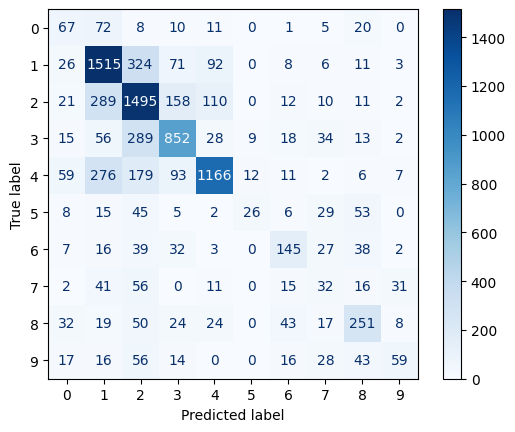


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       67        |       187        |
+-------+-----------------+------------------+
|   1   |      1515       |       800        |
+-------+-----------------+------------------+
|   2   |      1495       |       1046       |
+-------+-----------------+------------------+
|   3   |       852       |       407        |
+-------+-----------------+------------------+
|   4   |      1166       |       281        |
+-------+-----------------+------------------+
|   5   |       26        |        21        |
+-------+-----------------+------------------+
|   6   |       145       |       130        |
+-------+-----------------+------------------+
|   7   |       32        |       158        |
+-------+-----------------+------------------+
|   8   |       251       |       211        |
+-------+-----------------+------------------+
|   9   |    

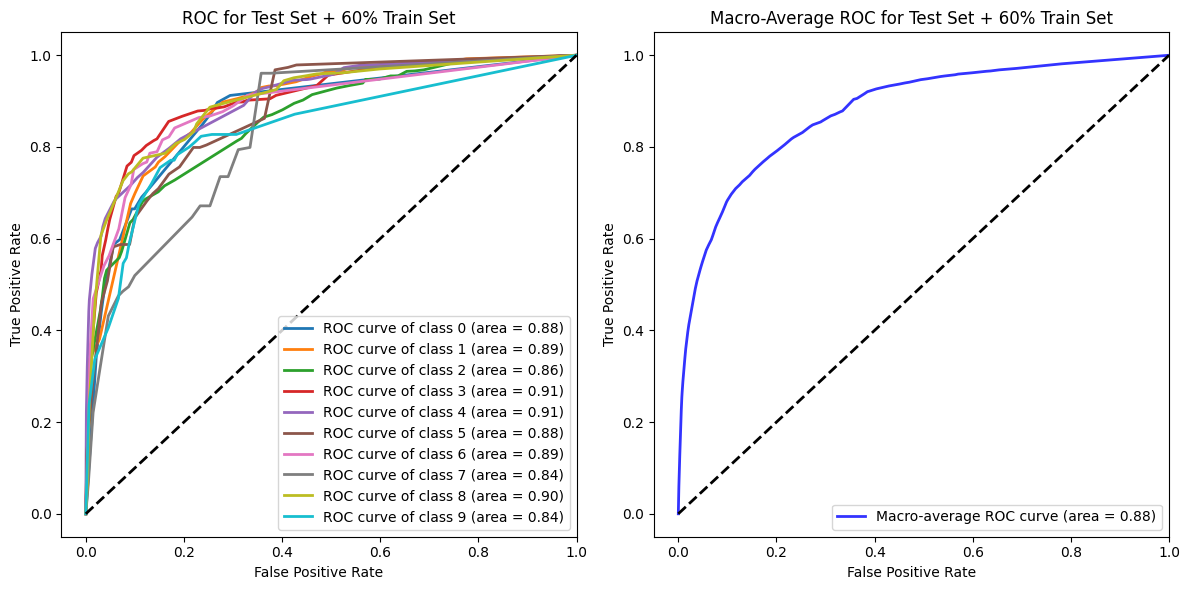

In [ ]:
# predictions using test set
y_pred_test60 = tree_clf_60.predict(x_test_60)
# probabilities using test set
y_prob_test60 = tree_clf_60.predict_proba(x_test_60)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_60_test = label_binarize(y_test_60, classes = classes)
y_pred_bin_60_test = label_binarize(y_pred_test60, classes = classes)

# Call functions for evaluation
display_cf_report(y_test_60, y_pred_test60)
display_TPR_FPR(y_test_60, y_pred_test60)
plot_confusion_matrix(y_test_60, y_pred_test60, classes)
list_TP_FP(y_test_bin_60_test, y_pred_bin_60_test)
plot_roc_curves(y_test_bin_60_test, y_prob_test60, "ROC for Test Set + 60% Train Set", "Macro-Average ROC for Test Set + 60% Train Set")

### **Data with Preprocessing**

In [ ]:
tree_clf_60p = DecisionTreeClassifier(random_state=42, min_samples_split=100, min_samples_leaf=25, max_depth=7)
tree_clf_60p.fit(x_train_60p, y_train_60)
display_accuracies(tree_clf_60p, x_train_60p, y_train_60, x_test_60p, y_test_60)

Accuracy on training set: 78.59%
Accuracy on testing set: 74.37%
Difference: 4.22%



Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.70      0.65        76
           1       0.83      0.84      0.83       884
           2       0.80      0.79      0.80       892
           3       0.67      0.77      0.72       544
           4       0.85      0.84      0.85       829
           5       0.61      0.42      0.50        81
           6       0.66      0.75      0.70       141
           7       0.60      0.58      0.59        96
           8       0.96      0.73      0.83       222
           9       0.72      0.59      0.65       111

    accuracy                           0.79      3876
   macro avg       0.73      0.70      0.71      3876
weighted avg       0.79      0.79      0.79      3876

True Positive Rate: [0.69736842 0.83710407 0.79484305 0.77389706 0.84439083 0.41975309
 0.75177305 0.58333333 0.72522523 0.59459459]
False Positive Rate: [0.00894737 0.05213904 0.05764075 0.06092437 0.03905481 0.0057

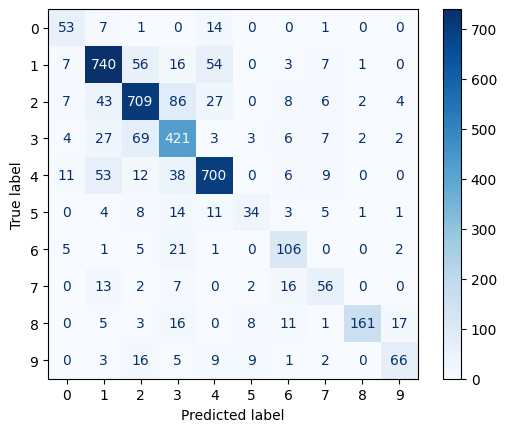


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       53        |        34        |
+-------+-----------------+------------------+
|   1   |       740       |       156        |
+-------+-----------------+------------------+
|   2   |       709       |       172        |
+-------+-----------------+------------------+
|   3   |       421       |       203        |
+-------+-----------------+------------------+
|   4   |       700       |       119        |
+-------+-----------------+------------------+
|   5   |       34        |        22        |
+-------+-----------------+------------------+
|   6   |       106       |        54        |
+-------+-----------------+------------------+
|   7   |       56        |        38        |
+-------+-----------------+------------------+
|   8   |       161       |        6         |
+-------+-----------------+------------------+
|   9   |    

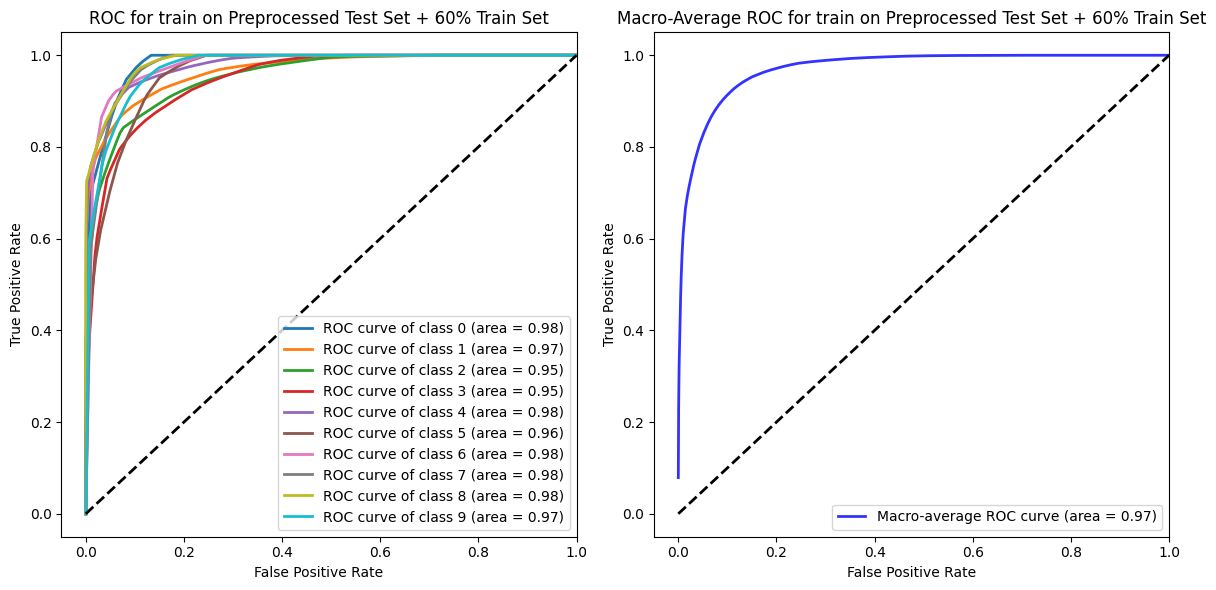

In [ ]:
# predictions using test set
y_pred_train60p = tree_clf_60p.predict(x_train_60p)
# probabilities using test set
y_prob_train60p = tree_clf_60p.predict_proba(x_train_60p)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_60_trainp = label_binarize(y_train_60, classes = classes)
y_pred_bin_60_trainp = label_binarize(y_pred_train60p, classes = classes)

# Call functions for evaluation
display_cf_report(y_train_60, y_pred_train60p)
display_TPR_FPR(y_train_60, y_pred_train60p)
plot_confusion_matrix(y_train_60, y_pred_train60p, classes)
list_TP_FP(y_test_bin_60_trainp, y_pred_bin_60_trainp)
plot_roc_curves(y_test_bin_60_trainp, y_prob_train60p, "ROC for train on Preprocessed Test Set + 60% Train Set", "Macro-Average ROC for train on Preprocessed Test Set + 60% Train Set")


Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.62      0.56       194
           1       0.80      0.81      0.80      2056
           2       0.75      0.78      0.77      2108
           3       0.63      0.66      0.64      1316
           4       0.84      0.81      0.83      1811
           5       0.66      0.54      0.59       189
           6       0.53      0.62      0.57       309
           7       0.48      0.43      0.45       204
           8       0.92      0.68      0.78       468
           9       0.73      0.63      0.68       249

    accuracy                           0.74      8904
   macro avg       0.69      0.66      0.67      8904
weighted avg       0.75      0.74      0.74      8904

True Positive Rate: [0.62371134 0.81031128 0.78178368 0.65653495 0.81060188 0.53968254
 0.62135922 0.42647059 0.67521368 0.63453815]
False Positive Rate: [0.0130884  0.0625     0.08078281 0.06826568 0.03820668 0.0059

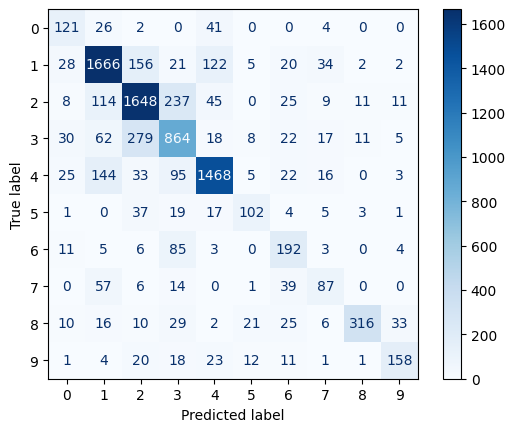


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       121       |       114        |
+-------+-----------------+------------------+
|   1   |      1666       |       428        |
+-------+-----------------+------------------+
|   2   |      1648       |       549        |
+-------+-----------------+------------------+
|   3   |       864       |       518        |
+-------+-----------------+------------------+
|   4   |      1468       |       271        |
+-------+-----------------+------------------+
|   5   |       102       |        52        |
+-------+-----------------+------------------+
|   6   |       192       |       168        |
+-------+-----------------+------------------+
|   7   |       87        |        95        |
+-------+-----------------+------------------+
|   8   |       316       |        28        |
+-------+-----------------+------------------+
|   9   |    

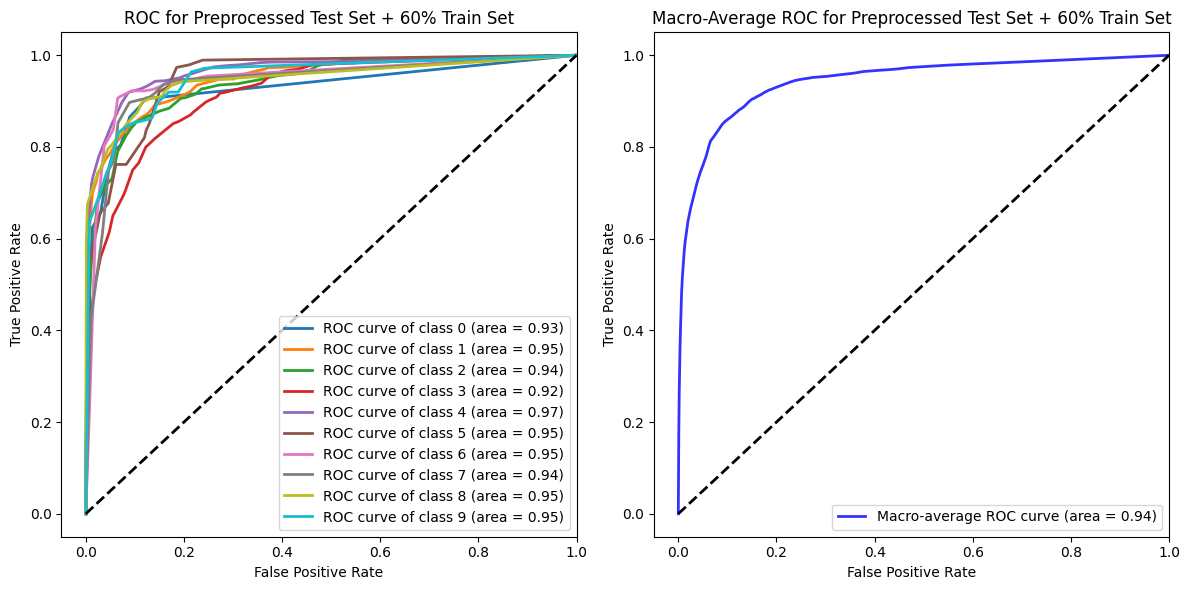

In [ ]:
# predictions using test set
y_pred_test60p = tree_clf_60p.predict(x_test_60p)
# probabilities using test set
y_prob_test60p = tree_clf_60p.predict_proba(x_test_60p)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_60_testp = label_binarize(y_test_60, classes = classes)
y_pred_bin_60_testp = label_binarize(y_pred_test60p, classes = classes)

# Call functions for evaluation
display_cf_report(y_test_60, y_pred_test60p)
display_TPR_FPR(y_test_60, y_pred_test60p)
plot_confusion_matrix(y_test_60, y_pred_test60p, classes)
list_TP_FP(y_test_bin_60_testp, y_pred_bin_60_testp)
plot_roc_curves(y_test_bin_60_testp, y_prob_test60p, "ROC for Preprocessed Test Set + 60% Train Set", "Macro-Average ROC for Preprocessed Test Set + 60% Train Set")

## **Conclusions**

* Even with a larger portion of the dataset moved to testing, preprocessing helps in achieving better accuracies. However, the difference between training and testing accuracies increases compared to the 30% scenario, which is expected since the model is trained on less data. Still, preprocessing contributes to a smaller gap than without preprocessing, suggesting it plays a role in reducing overfitting.
* With 60% moved, training accuracy is 78.59% and testing is 74.37%, showing a wider but still reduced gap (4.22%), compared to the larger differences without preprocessing (7.59% and 7.06%, respectively).
* The values for the un-preprocessed data were lower because there was noise and irrelevant variations in the data likely influence the model, hindering its ability to generalize to new, unseen data. This issue is slightly amplified when the proportion of training data is reduced, as the model has fewer examples to learn from, increasing its susceptibility to overfitting.

# **Random Forest Decision Tree**

## **Implement Random forest classifier on the training set**

In [ ]:
from sklearn.datasets import make_classification
clf = RandomForestClassifier(random_state=42)
clf.fit(x_train, y_train.to_numpy().ravel())
y_pred = clf.predict(x_train)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


<ipython-input-8-3d35aa5ad3e2>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_clf.fit(x_train, y_train)



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690

True Positive Rate: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
False Positive Rate: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Average True Positive Rate: 1.0
Average False Positive Rate: 0.0


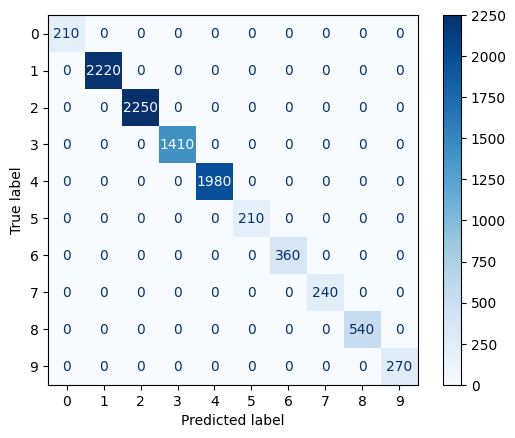


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |       210       |        0         |
+-------+-----------------+------------------+
|   1   |      2220       |        0         |
+-------+-----------------+------------------+
|   2   |      2250       |        0         |
+-------+-----------------+------------------+
|   3   |      1410       |        0         |
+-------+-----------------+------------------+
|   4   |      1980       |        0         |
+-------+-----------------+------------------+
|   5   |       210       |        0         |
+-------+-----------------+------------------+
|   6   |       360       |        0         |
+-------+-----------------+------------------+
|   7   |       240       |        0         |
+-------+-----------------+------------------+
|   8   |       540       |        0         |
+-------+-----------------+------------------+
|   9   |    

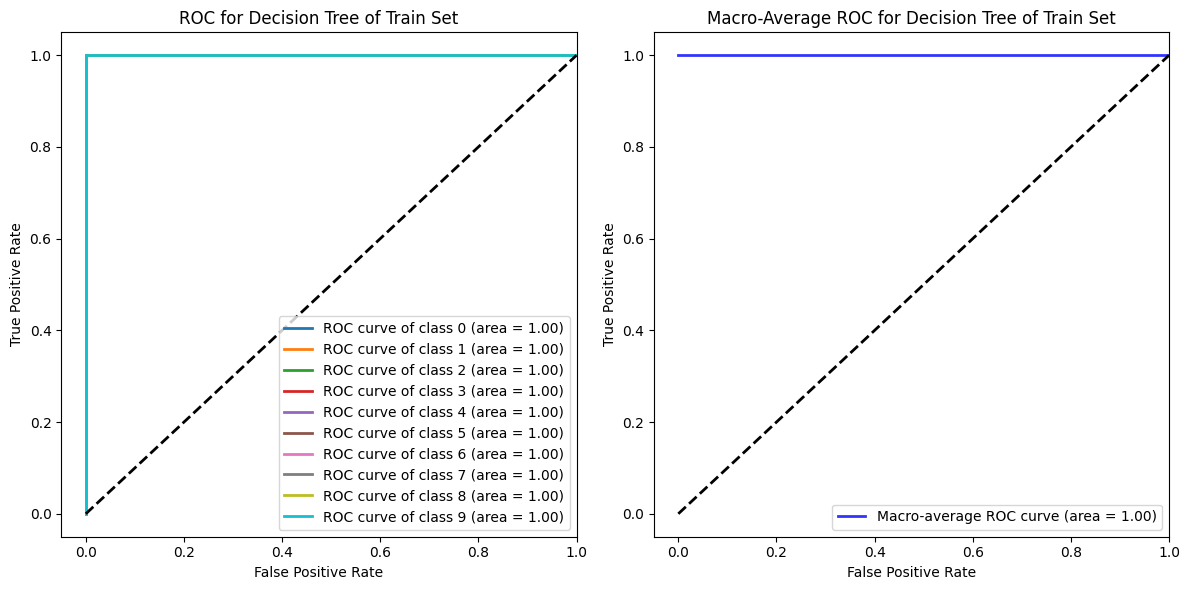

In [ ]:
y_pred_og, y_proba_og = fit_tree_clf(clf, x_train, y_train)

# Binarize the labels for multi-label/multi-class ROC
y_test_bin_og = label_binarize(y_train, classes = classes)
y_pred_bin_og = label_binarize(y_pred_og, classes = classes)

# Call functions for evaluation
display_cf_report(y_train, y_pred_og)
display_TPR_FPR(y_train, y_pred_og)
plot_confusion_matrix(y_train, y_pred_og, classes)
list_TP_FP(y_test_bin_og, y_pred_bin_og)
plot_roc_curves(y_test_bin_og, y_proba_og, "ROC for Decision Tree of Train Set", "Macro-Average ROC for Decision Tree of Train Set")

## **Make and evaluate Decision Tree using 10-Fold CV**

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_accuracies = cross_val_score(clf, x_train, y_train.to_numpy().ravel(), cv=kfold, scoring='accuracy')
print("Accuracies:", cross_val_accuracies)
print(f"Average accuracy: {np.mean(cross_val_accuracies)*100:.1f}%")

Accuracies: [0.9752322  0.98245614 0.97832817 0.97213622 0.97626419 0.97316821
 0.97729618 0.98245614 0.97832817 0.97832817]
Average accuracy: 97.7%


In [ ]:
scoring_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = cross_validate(clf, x_train, y_train.to_numpy().ravel(), cv=kfold, scoring=scoring_list)
scores_df = pd.DataFrame(accuracies)
scores_df.mean()

fit_time                30.967475
score_time               0.150944
test_accuracy            0.977399
test_precision_macro     0.986145
test_recall_macro        0.966536
test_f1_macro            0.975686
test_roc_auc_ovr         0.999035
dtype: float64

## **Make and evaluate Decision Tree using stratified 10-Fold CV**

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = cross_val_score(clf, x_train, y_train.to_numpy().ravel(), cv=stratified_kfold, scoring='accuracy')
print("Accuracies:", accuracies)
print(f"Average accuracy: {np.mean(accuracies)*100:.1f}%")

Accuracies: [0.97420021 0.9752322  0.98348813 0.98039216 0.9752322  0.98348813
 0.9752322  0.9752322  0.97626419 0.97832817]
Average accuracy: 97.8%


In [ ]:
scoring_list = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = cross_validate(clf, x_train, y_train.to_numpy().ravel(), cv=stratified_kfold, scoring=scoring_list)
scores_df = pd.DataFrame(accuracies)
scores_df.mean()

fit_time                 19.574974
score_time                0.099434
test_accuracy             0.663571
train_accuracy            1.000000
test_precision_macro      0.588344
train_precision_macro     1.000000
test_recall_macro         0.579009
train_recall_macro        1.000000
test_f1_macro             0.573094
train_f1_macro            1.000000
test_roc_auc_ovr          0.769187
train_roc_auc_ovr         1.000000
dtype: float64

## **Tuning 2 Hyper parameters: Trying out different values for max depth and min samples split**

In [ ]:
values1 = [9,9,9,9,9,9,9,9,9,9,9,9]
values2 = [420, 440, 470, 490, 500, 520, 550, 580, 600, 650]
tuning2Params(RandomForestClassifier, x_train, x_test, y_train.to_numpy().ravel(), y_test.to_numpy().ravel(), 'max_depth', values1, 'min_samples_split', values2)

   max_depth  min_samples_split  Train Score  Test Score  Difference
0          9                420    72.476780   62.071197   10.405583
1          9                440    72.156863   61.650485   10.506377
2          9                470    70.970072   61.359223    9.610849
3          9                490    70.350877   60.517799    9.833078
4          9                500    69.927761   60.420712    9.507049
5          9                520    69.721362   60.485437    9.235925
6          9                550    68.720330   59.126214    9.594117
7          9                580    68.875129   59.320388    9.554741
8          9                600    68.679051   59.288026    9.391025
9          9                650    66.326109   57.637540    8.688569


- Over here we found that max depth value of 9 and min samples split value of 470 got the least train and test score difference and better test accuracy.

## **Tuning 3 Hyper parameters: Trying out different values for max depth, min samples split and min samples leaf**

In [ ]:
min_samples_split = [470,470,470,470,470,470,470,470,470,470,470,470,470,470,470]
min_samples_leaf = [30,32,35,40,45,47,52,54,58,63,67,70,73,76,80]
max_depth = [9,9,9,9,9,9,9,9,9,9,9,9,9,9,9]
tuning(RandomForestClassifier, x_train, x_test, y_train.to_numpy().ravel(), y_test.to_numpy().ravel(), min_samples_split, min_samples_leaf, max_depth)

    Min Split  Min Leaf  Max Depth  Train Score  Test Score  Difference
0         470        30          9    70.897833   61.132686    9.765147
1         470        32          9    70.856553   61.067961    9.788592
2         470        35          9    70.866873   61.100324    9.766549
3         470        40          9    70.804954   61.035599    9.769355
4         470        45          9    70.846233   60.841424   10.004809
5         470        47          9    70.670795   60.809061    9.861733
6         470        52          9    70.557276   60.744337    9.812939
7         470        54          9    70.619195   60.550162   10.069033
8         470        58          9    70.629515   60.776699    9.852816
9         470        63          9    70.670795   60.679612    9.991183
10        470        67          9    70.464396   60.517799    9.946597
11        470        70          9    70.454076   60.258900   10.195177
12        470        73          9    70.350877   60.323625   10

- Taking the above values and trying it out with different values of min samples leaf we get a value of 30 for min samples resulting in the least train and test score difference and better test accuracy.

In [ ]:
# tuning(RandomForestClassifier, x_train, x_test, y_train.to_numpy().ravel(), y_test.to_numpy().ravel(), [100], [25], [7])

   Min Split  Min Leaf  Max Depth  Train Score  Test Score  Difference
0        100        25          7    84.458204    66.31068   18.147525


In [ ]:
# tuning(RandomForestClassifier, x_train, x_test, y_train.to_numpy().ravel(), y_test.to_numpy().ravel(), [75], [22], [10])

   Min Split  Min Leaf  Max Depth  Train Score  Test Score  Difference
0         75        22         10    91.960784   73.236246   18.724538


## **Move 30% instances from original training set to test set**

### **Trying out optimal hyper parameters**

In [ ]:
tree_clf_30 = RandomForestClassifier(random_state=42, min_samples_split=470, min_samples_leaf=30, max_depth=9)
tree_clf_30.fit(x_train_30, y_train_30.to_numpy().ravel())
display_accuracies(tree_clf_30, x_train_30, y_train_30, x_test_30, y_test_30)

Accuracy on training set: 66.28%
Accuracy on testing set: 60.56%
Difference: 5.72%


In [ ]:
# tree_clf_30 = RandomForestClassifier(random_state=42, min_samples_split=75, min_samples_leaf=22, max_depth=10)
# tree_clf_30.fit(x_train_30, y_train_30.to_numpy().ravel())
# display_accuracies(tree_clf_30, x_train_30, y_train_30, x_test_30, y_test_30)

Accuracy on training set: 89.41%
Accuracy on testing set: 76.71%
Difference: 12.71%



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.06      0.11       135
           1       0.72      0.85      0.78      1385
           2       0.78      0.82      0.80      1428
           3       0.76      0.81      0.78       876
           4       0.81      0.80      0.80      1247
           5       1.00      0.29      0.45       131
           6       0.71      0.58      0.64       190
           7       0.95      0.50      0.65       125
           8       0.71      0.71      0.71       308
           9       0.90      0.58      0.71       172

    accuracy                           0.77      5997
   macro avg       0.83      0.60      0.64      5997
weighted avg       0.78      0.77      0.76      5997

True Positive Rate: [0.05925926 0.85415162 0.82282913 0.80707763 0.79951885 0.29007634
 0.58421053 0.496      0.71103896 0.58139535]
False Positive Rate: [0.         0.09930616 0.07156927 0.04354618 0.05031579 0.
 0.

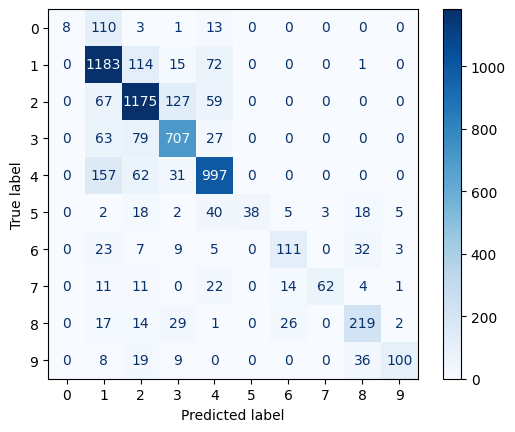


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |        8        |        0         |
+-------+-----------------+------------------+
|   1   |      1183       |       458        |
+-------+-----------------+------------------+
|   2   |      1175       |       327        |
+-------+-----------------+------------------+
|   3   |       707       |       223        |
+-------+-----------------+------------------+
|   4   |       997       |       239        |
+-------+-----------------+------------------+
|   5   |       38        |        0         |
+-------+-----------------+------------------+
|   6   |       111       |        45        |
+-------+-----------------+------------------+
|   7   |       62        |        3         |
+-------+-----------------+------------------+
|   8   |       219       |        91        |
+-------+-----------------+------------------+
|   9   |    

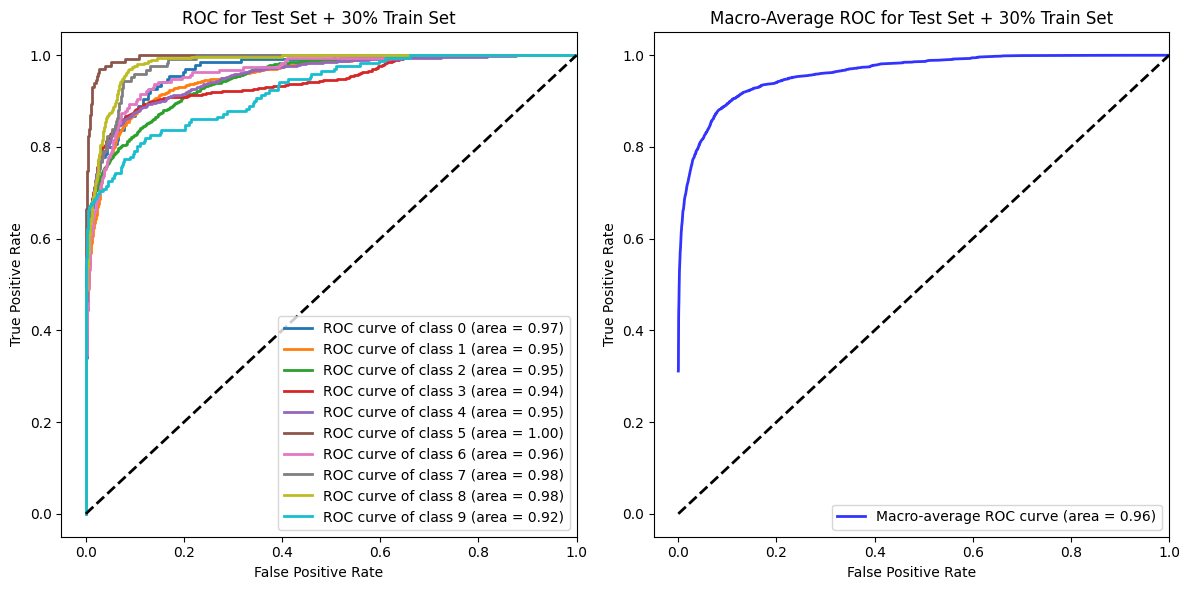

In [ ]:
# # predictions using test set
# y_pred_test30 = tree_clf_30.predict(x_test_30)
# # probabilities using test set
# y_prob_test30 = tree_clf_30.predict_proba(x_test_30)

# # Binarize the labels for multi-label/multi-class ROC
# y_test_bin_30_test = label_binarize(y_test_30, classes = classes)
# y_pred_bin_30_test = label_binarize(y_pred_test30, classes = classes)

# # Call functions for evaluation
# display_cf_report(y_test_30, y_pred_test30)
# display_TPR_FPR(y_test_30, y_pred_test30)
# plot_confusion_matrix(y_test_30, y_pred_test30, classes)
# list_TP_FP(y_test_bin_30_test, y_pred_bin_30_test)
# plot_roc_curves(y_test_bin_30_test, y_prob_test30, "ROC for Test Set + 30% Train Set", "Macro-Average ROC for Test Set + 30% Train Set")

In [ ]:
# tree_clf_60 = RandomForestClassifier(random_state=42, min_samples_split=75, min_samples_leaf=22, max_depth=10)
# tree_clf_60.fit(x_train_60, y_train_60.to_numpy().ravel())
# display_accuracies(tree_clf_60, x_train_60, y_train_60, x_test_60, y_test_60)

Accuracy on training set: 84.29%
Accuracy on testing set: 72.94%
Difference: 11.34%


## **Move 60% instances from original training set to test set**

### **Trying out optimal hyper parameters**

In [ ]:
tree_clf_60 = RandomForestClassifier(random_state=42, min_samples_split=470, min_samples_leaf=30, max_depth=9)
tree_clf_60.fit(x_train_60, y_train_60.to_numpy().ravel())
display_accuracies(tree_clf_60, x_train_60, y_train_60, x_test_60, y_test_60)

Accuracy on training set: 59.29%
Accuracy on testing set: 54.10%
Difference: 5.19%



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.02      0.04       194
           1       0.73      0.82      0.77      2056
           2       0.71      0.79      0.75      2108
           3       0.71      0.74      0.73      1316
           4       0.78      0.83      0.80      1811
           5       1.00      0.05      0.09       189
           6       0.70      0.45      0.55       309
           7       1.00      0.34      0.51       204
           8       0.61      0.69      0.65       468
           9       0.83      0.48      0.61       249

    accuracy                           0.73      8904
   macro avg       0.81      0.52      0.55      8904
weighted avg       0.75      0.73      0.71      8904

True Positive Rate: [0.02061856 0.82052529 0.78842505 0.74316109 0.83158476 0.04761905
 0.44660194 0.33823529 0.69017094 0.47791165]
False Positive Rate: [0.         0.08936916 0.09917599 0.05311017 0.06090512 0.
 0.

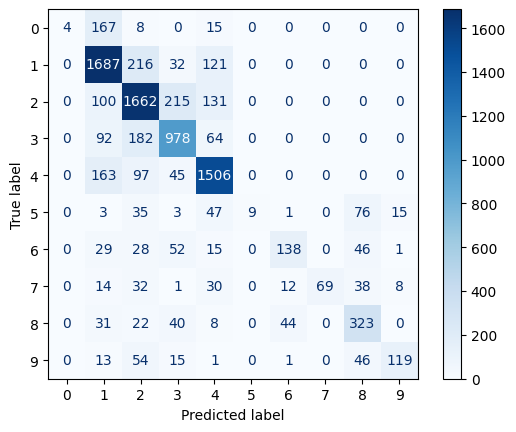


________________________________________________________________________



+-------+-----------------+------------------+
| Class | True Positives  | False Positives  |
+-------+-----------------+------------------+
|   0   |        4        |        0         |
+-------+-----------------+------------------+
|   1   |      1687       |       612        |
+-------+-----------------+------------------+
|   2   |      1662       |       674        |
+-------+-----------------+------------------+
|   3   |       978       |       403        |
+-------+-----------------+------------------+
|   4   |      1506       |       432        |
+-------+-----------------+------------------+
|   5   |        9        |        0         |
+-------+-----------------+------------------+
|   6   |       138       |        58        |
+-------+-----------------+------------------+
|   7   |       69        |        0         |
+-------+-----------------+------------------+
|   8   |       323       |       206        |
+-------+-----------------+------------------+
|   9   |    

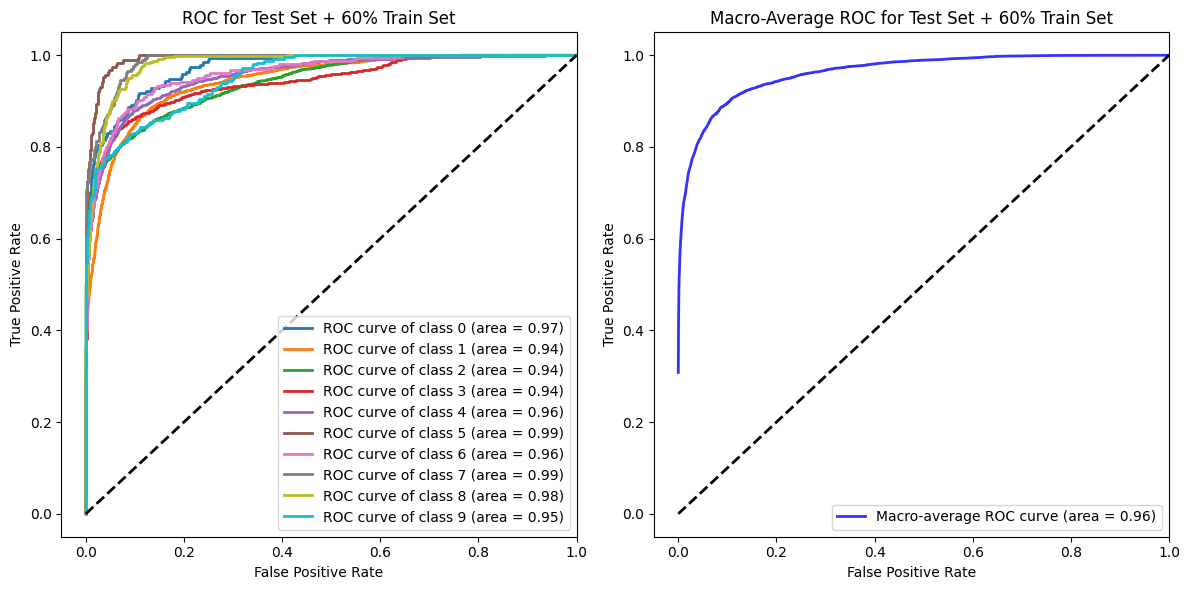

In [ ]:
# # predictions using test set
# y_pred_test60 = tree_clf_60.predict(x_test_60)
# # probabilities using test set
# y_prob_test60 = tree_clf_30.predict_proba(x_test_60)

# # Binarize the labels for multi-label/multi-class ROC
# y_test_bin_60_test = label_binarize(y_test_60, classes = classes)
# y_pred_bin_60_test = label_binarize(y_pred_test60, classes = classes)

# # Call functions for evaluation
# display_cf_report(y_test_60, y_pred_test60)
# display_TPR_FPR(y_test_60, y_pred_test60)
# plot_confusion_matrix(y_test_60, y_pred_test60, classes)
# list_TP_FP(y_test_bin_60_test, y_pred_bin_60_test)
# plot_roc_curves(y_test_bin_60_test, y_prob_test60, "ROC for Test Set + 60% Train Set", "Macro-Average ROC for Test Set + 60% Train Set")